<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [13]</a>'.</span>

In [1]:
"""from google.colab import drive
drive.mount('/content/gdrive/')

!pip install -q condacolab
import condacolab
condacolab.install()

%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests
!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert
!pip install papermill[all]
!pip install torchvision"""

"from google.colab import drive\ndrive.mount('/content/gdrive/')\n\n!pip install -q condacolab\nimport condacolab\ncondacolab.install()\n\n%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests\n!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert\n!pip install papermill[all]\n!pip install torchvision"

In [2]:
import pdb
import torch, os
import argparse, datetime
import gc,time
from tqdm import tqdm
import __init__



#from src.gp_cpab.src.transformation.gp_cpab import gp_cpab
#from src.gp_cpab.src.transformation.gp_cpab_tmp import gp_cpab
from src.gp_cpab.src.transformation.configManager import configManager
from src.gp_cpab.src.extra.experiment_utilities import *

from src.models.trainer_tmp import vae_trainer
from src.unsuper.unsuper.data.mnist_data_loader import mnist_data_loader
from src.unsuper.unsuper.data.perception_data_loader import perception_data_loader
from src.unsuper.unsuper.helper.utility import model_summary
from src.models.encoder_decoder import get_encoder, get_decoder, get_list_encoders, get_list_decoders
from src.models import get_model

from src.seqsDataLoader import seqsReader, seqsDatasetLoader, Sequence_Data_Loader
from src.dataLoaderDiffeo import *

#from src.models.experimental.vitae_ci_gp_detached_deepseq import vitae_ci_gp_no_deepseq
from src.models.experimental.PGM_LA_latent_alignment import PGM_LA_latent_alignment
from src.models.experimental.deepsequence import DeepSequence

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Could not import libcpab, error was
No module named 'libcpab'


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
import argparse; import sys; sys.argv=['']; del sys
import math

def define_prior_init(channels, space='log'):
    prior_init = []
    base_alpha = channels-2

    if space=='log':
        #prior_init = [math.log(1e-6)]*channels
        prior_init = [math.log(1e-6), *([ math.log(1/base_alpha) ]*base_alpha)]
    else:
        # Current Approach
        #prior_init = [0.0, *([1/base_alpha]*base_alpha)]
        #prior_init = [0.0, 0.0, *([1/base_alpha]*base_alpha)]


        # Approach A for avoiding flat landscape in the optimization - avoiding local optima
        prior_init = [1.0, 0.0, *([0.0]*base_alpha) ]

    return prior_init

def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # Model settings
    ms = parser.add_argument_group('Model settings')
    ms.add_argument('--model', type=str, default='vitae_ci', help='model to train')
    ms.add_argument('--ed_type', type=str, default='mlp,mlp', help='encoder/decoder type')
    ms.add_argument('--stn_type', type=str, default='gp_cpab', help='transformation type to use')
    ms.add_argument('--beta', type=float, default=16, help='beta value for beta-vae model') #16
    
    # Training settings
    ts = parser.add_argument_group('Training settings')
    ts.add_argument('--n_epochs', type=int, default=500, help='number of epochs of training')
    ts.add_argument('--eval_epoch', type=int, default=5, help='when to evaluate log(p(x))')
    ts.add_argument('--batch_size', type=int, default=10, help='size of the batches') # batch=10,warmup=10, epochs=100
    ts.add_argument('--warmup', type=int, default=5, help='number of warmup epochs for kl-terms')
    ts.add_argument('--lr', type=float, default=1e-3, help='learning rate for adam optimizer') # 1e-5 for 2 sequence deepseq 2 seqs other# 1e-3, 1e-7 # weird case for 550 iters and 1e-4, works in trans but regular in reconstruction
    
    # Paths to use
    paths = parser.add_argument_group('Paths')
    #paths.add_argument('--path_orig', type=str, default="../data/WW10seeds_rawnoHoles2.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    #paths.add_argument('--path_aligned_orig', type=str, default="../data/WW10seeds_MSAnoHoles2.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_orig', type=str, default="../data/set_preprint/WWseeds_tunningPGM_set.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_aligned_orig', type=str, default="../data/set_preprint/WWseeds_aligned_for_pretrained.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
 

    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear3.pth", help='prebuilt model using linear case') 
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB3.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report') 
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')

    gpsetup = parser.add_argument_group('GPSetup')
    #gpsetup.add_argument('--Task', type=int, default = 8, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143], help='multitaks-gp initialization') 
    gpsetup.add_argument('--Task', type=int, default = 22, help='Amount of channels in multitask-gp estimator')
    gpsetup.add_argument('--Initialization', type=list, default = define_prior_init(22, space='default'), help='multitaks-gp initialization') # before it was 19 and works good in current setup with uniform distributed values in prior
    #gpsetup.add_argument('--Task', type=int, default = 11, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], help='multitaks-gp initialization') #[0.0, 0.33, 0.33, 0.33] #[0.5, 0.5]
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.5, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [1e-3,1e-1], help='noise constrain -- [lower_bound, upper_bound]') #16
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="gpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=80, help='number of tesselation cells') #6
    cpab.add_argument('--channels', type=int, default=80, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps') 

    # Hyper settings
    hp = parser.add_argument_group('Variational settings')
    hp.add_argument('--latent_dim', type=int, default=40, help='dimensionality of the latent space') #40, 5, 10, 40 is the bst one for WW
    hp.add_argument('--density', type=str, default='softmax', help='output density')  # bernoulli  gaussian
    hp.add_argument('--eq_samples', type=int, default=1, help='number of MC samples over the expectation over E_q(z|x)')
    hp.add_argument('--iw_samples', type=int, default=1, help='number of importance weighted samples')
    
    
    # Parse and return
    args = parser.parse_args()
    return args

In [4]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)

device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
beta = std.parserinfo('beta')
#lossmetric = std.parserinfo('lossfunctmetric')

path = std.parserinfo('path_orig')
path_aligned = std.parserinfo('path_aligned_orig')
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')

#self.config, self.constrain, self.tasks, self.interpolation_type, self.option 
gp_params = std.get_config_vals(['noise_constraint','Task','interpolation_type','Option','Lengthscale','Initialization'])

#alphabets = ['-', 'A', 'D', 'G', 'I', 'L', 'R', 'S'] # for two long sequences
#alphabets = ['-', 'A', 'E', 'F', 'G', 'L', 'Q', 'R', 'S', 'T', 'V'] # ['-', 'L', 'Q', 'R'] #-> for 10 sequences case
#alphabets = ['-', 'A', 'D', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'S', 'T', 'V', 'W'] #-> for antiviral peptides
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_AntiviralPEP.pth'

#alphabets = ['-', 'A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> WW 4 seqs
alphabets = ['?','-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences
#alphabets = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences


#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW10NoSeed_22channels.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1_v2.pth'

'''trained_model_WW_22_simplex9990_channel_seeds_PGM1_v2_debug.pth is the one that works fine'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_simplex9990_channel_seeds_PGM1_v2_debug.pth'

'''this would be with the seeds samples (40 aas)'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_seeds_40aas_nov2023_4.pth'

'''for seeds samples'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22__channel_CompleteSeeds_PGM1_v2_debug.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22__channel_CompleteSeeds_PGM1_v2_debug_2000iter.pth'

'''for preprint'''
logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_preprint_PGM1_21nov2023.pth'

print('Ok')

None
Ok


In [5]:
from src.gp_cpab.src.extra import experiment_utilities
from src.dataLoaderDiffeo import datasetLoader

# Raw Sequences, to see if we can align the sequences somehow

c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)
dataset_msa = seqsDatasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True, device=device)
#x1 = dataset_msa.prot_space
dataset_aligned_msa = seqsDatasetLoader(pathBLAT_data = path_aligned, alphabet = alphabets, enable_variable_length=True, device=device)

'''--------------------------------------------------------------------------------------------------------------------------'''
'''dataset_msa.prot_space = replace_target_token_gaps(dataset_msa.prot_space, c2i, '-')[:,:,1:]
dataset_aligned_msa.prot_space = replace_target_token_gaps(dataset_aligned_msa.prot_space, c2i, '-')[:,:,1:]
alphabets=['L','Q','R']
c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)'''
'''--------------------------------------------------------------------------------------------------------------------------'''

# Load data
print('Loading data')

batches = args.batch_size #16 # 448

# initially the dimension is [448, 34, 21]. However as it is necesary to ignore 
# the batch size, I just create a tuple, by taking just the last 2 components from the size
trainloader, testloader = Sequence_Data_Loader(dataset_msa, dataset_test=None, batch_size=batches)
trainloader_pretrainer, testloader_pretrainer = Sequence_Data_Loader(dataset_aligned_msa, dataset_test=None, batch_size=112)
#trainloader2, testloader2 = Sequence_Data_Loader(dataset_msa2, dataset_test=None, batch_size=batches)


seq_size = ( [*dataset_msa.prot_space.shape][1:])

/home/kvr226/Explicit_Disentanglement_Molecules/src/seqsDataLoader.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prot_space = torch.tensor(self.prot_space, dtype=torch.float32, device=device)


Loading data


Loading Deformation Model...
Loaded


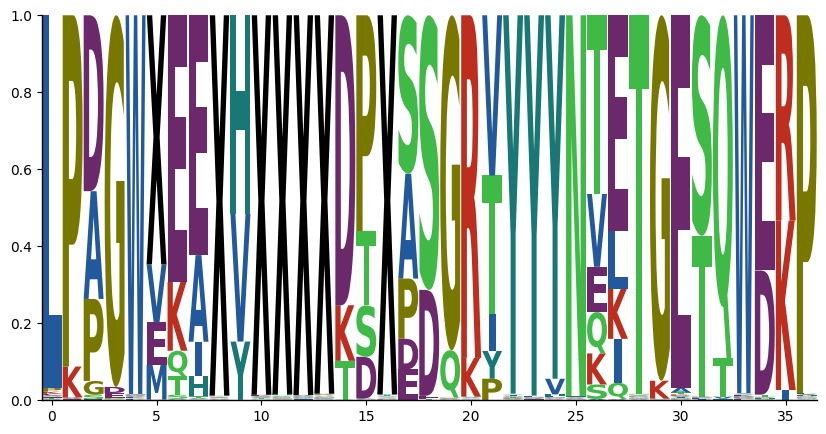

In [6]:
# Loading BLAT dataset
deepseq = DeepSequence(seq_size, args.latent_dim, alphabets, device = device)
optimizer_deepseq = torch.optim.AdamW(deepseq.parameters(), lr=args.lr)
loss_function = LossFunctionsAlternatives()
pretrained_deepseq_path = logdir + "/" + outmodel_name
check_parameter_historic = []

casted_device = "cuda" if device=="gpu" or device=="cuda" else "cpu" if device=='cpu'else 'mps'

if os.path.isfile(pretrained_deepseq_path):
    print ("Loading Deformation Model...")
    deepseq.load_state_dict( torch.load(pretrained_deepseq_path, map_location=casted_device) )
    print ("Loaded")
    #for param in deepseq.parameters():
    #    param.requires_grad = False
else:
    deepseq.training_representation(trainloader_pretrainer, loss_function, optimizer_deepseq, 1000, 1, logdir=logdir, out_modelname=outmodel_name, beta=1 )
    #check_parameter_historic = list(deepseq.parameters())
    #2500 iters before to make it converge in a good optima
    #for param in deepseq.parameters():
    #    param.requires_grad = False

deepseq(dataset_msa.prot_space)
plot_logos_probs(deepseq(dataset_msa.prot_space)[0], alphabets)


In [7]:
import matplotlib.pyplot as plt
import src.gp_cpab.src.extra.utilities as ut
import matplotlib.gridspec as gridspec
import logomaker 


def get_GPinterpolation(TT, theta, Y, Ug,  n_batch, grid_length_for_GP, seq_len):
    grids_trans_out = (TT.transform_grid(TT.grid,theta)*(seq_len - 1)).squeeze(1)
    # creating the likelihood for interpolation
    batch_Multitask_model, batch_multitask_likelihood = TT.sets_MultioutputGP_per_batches(grids_trans_out, Y, n_batch)
    # To get distribution over Posteriors
    trans_data, _, \
            lower,upper  = TT.predict_operation(Ug, batch_Multitask_model, batch_multitask_likelihood  )
    trans_data = torch.reshape(trans_data, (n_batch, grid_length_for_GP, Y.shape[2]))
    lower = torch.reshape( lower, (n_batch, grid_length_for_GP, Y.shape[2]) )
    upper = torch.reshape( upper, (n_batch, grid_length_for_GP, Y.shape[2]) )

    return grids_trans_out, trans_data, lower, upper

def plot_GP_components_per_seq(Ug, gT, Trdata, Lw, Up, nrows, ncols, alphabets, title, fig):

    for j, axs in enumerate(fig.axes[(nrows-1)*ncols : nrows*ncols]):
        axs.plot( Ug.flatten().detach().numpy(), Trdata[:,j].detach().numpy(), 'b' )
        axs.fill_between(Ug.flatten().detach().numpy(), Lw[:,j].detach().numpy(),  Up[:,j].detach().numpy(), alpha=0.3)
        axs.legend([ 'Mean'])
        axs.set_xticks( Ug.flatten().detach().numpy(), minor= True )
        axs.axhline(0, color='grey', linewidth=0.8)
        axs.set_title(alphabets[j])
    
    #fig.tight_layout()
    
 
def create_gridSpec_graphs(ncols=4,nrows=2,figsize=(25,12)):
    fig = plt.figure(figsize=figsize) #(constrained_layout=True)
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    for i in range(0, nrows):
        for j in range(0,ncols):
            fig.add_subplot(gs[i, j])
    return fig, gs

def plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig2):
    for cont,(U,gT, Trdata,Lw,Up) in enumerate(list(zip(Ug,grids_trans_out, trans_data,lower,upper))):
        title='sequence {0}'.format(cont+1)
        plot_GP_components_per_seq(U, gT, Trdata, Lw, Up, cont+1, Trdata.shape[1], alphabets=alphabets, title=title, fig = fig2)

def heatmap_from_tensor_tmp(data, alphabet, title):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    figure, ax = plt.subplots(figsize=(8,10))
    #ax = plt.axes()
    px = pd.DataFrame(data, columns=alphabet)
    ff=sns.heatmap(px, linewidth=1, linecolor='w', annot=data, ax = ax)
    ax.set_title(title)
    plt.show()

def plot_msa_from_preds(ts_aligned, alphabet, figsize = (5,4), show_axis=True):
    fig, gs = create_gridSpec_graphs(ncols=1,nrows=ts_aligned.shape[0], figsize=figsize); fig.suptitle('MSA', fontsize='large')

    alphabets_logo = [ i if i!='-' else 'X' for i in alphabet] 
    for cont, x_aligned in enumerate(ts_aligned):
        domain_info_df = df_construction_aas([ x_aligned.unsqueeze(0).detach().numpy() ], x_aligned.unsqueeze(0).shape, alphabets_logo)
        
        if show_axis == False:
            fig.axes[cont].get_xaxis().set_visible(False)
            fig.axes[cont].get_yaxis().set_visible(False)

        logomaker.Logo(domain_info_df,
                          color_scheme = 'NajafabadiEtAl2017',
                          ax = fig.axes[cont],
                          figsize=figsize, show_spines=False)



# recon_data_train = model(dataset_msa.prot_space, deepseq)
def get_GP_behavior_from_model_alignment(data,model, DS, len_grid = 13 , alphabets=['-','L','Q','R']):
    model.eval()
    Y = data
    recon_data_train = model(data, DS)

    x1_trans = recon_data_train[5]

    out_DS_before_dir_trans = DS(x1_trans)[0]

    TT=model.stn.st_gp_cpab
    TT.interpolation_type = 'GP'
    grid_length_for_GP = len_grid


    #get the transformation from Big model
    _, theta = model.sample_only_trans(Y)
    seq_len = Y.shape[1]; n_batch = Y.shape[0]

    ''' info about initial deformation '''
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
    initialTT_raw = TT.grid
    initialTT_inv = TT.transform_grid(TT.grid,-theta)
    initialTT_dir = TT.transform_grid(TT.grid,theta)
    forward = torch.stack([initialTT_raw.flatten() ,initialTT_inv.flatten(), (initialTT_inv*(x1_trans.shape[1]-1)).flatten() ]).T
    backward = torch.stack([initialTT_raw.flatten() ,initialTT_dir.flatten(), (initialTT_dir*(x1_trans.shape[1]-1)).flatten() ]).T
    heatmap_from_tensor_tmp(forward.detach().numpy(), ['input','raw','scaled'], 'FORWARD SCHEME' )
    heatmap_from_tensor_tmp(backward.detach().numpy(), ['input','raw','scaled'], 'BACKWARD SCHEME' )
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''

    # grid creations and deformations based on theta estimated from big model

    Ug=TT.uniform_meshgrid((grid_length_for_GP,grid_length_for_GP)).repeat(n_batch,1,1)*(seq_len - 1)
    
    grids_trans_out, trans_data, lower, upper = get_GPinterpolation(TT, -theta, Y, Ug, n_batch, grid_length_for_GP, seq_len)
    grids_dir_trans_out, dir_trans_data, lower_dir, upper_dir = get_GPinterpolation(TT, theta, out_DS_before_dir_trans, Ug, n_batch, grid_length_for_GP, seq_len)

    ncols= grids_trans_out.shape[-1]; nrows = Ug.shape[0]
    fig, gs = create_gridSpec_graphs(ncols=ncols,nrows=nrows, figsize=(25,20)); fig.suptitle('Sequence Alignment by Transformation', fontsize='large')
    figdir, gsdir = create_gridSpec_graphs(ncols=ncols,nrows=nrows,figsize=(25,20)); figdir.suptitle('Sequence Reconstruction', fontsize='large')
    
    plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig)
    plot_GP_components_alignment_channel(Ug,grids_dir_trans_out, dir_trans_data,lower_dir,upper_dir, figdir)



#x = deepseq(trainloader_pretrainer.dataset.prot_space)
#plot_msa_from_preds(x[0], alphabets, figsize=(15,10), show_axis=False)



In [8]:
import time

def update_behavior_loss_batches(batch_loss_dict, batch_key, batch_historical):
    if batch_key not in batch_loss_dict:
        batch_loss_dict[batch_key] =  [batch_historical]
    else:
        batch_loss_dict[batch_key].append(batch_historical)

def batch_plots(batch_loss_dict):
    import matplotlib.pyplot as plt

    if len(batch_loss_dict.keys())==1:
         values= batch_loss_dict[ list(batch_loss_dict.keys())[0] ]
         epochs_i = list(range(0,len(values)))
         plt.plot(epochs_i, values)
    else:
        fig, ax = plt.subplots(len(batch_loss_dict.keys()),1, figsize=(4,10))
        fig.tight_layout()

        for i in batch_loss_dict.keys():
            y = batch_loss_dict[i]
            x = list(range(0,len(y)))
            ax[i].set_title('Batch ' + str(i))
            ax[i].plot(x,y)

    plt.show()
        
def fit_VITAE_with_pretrained_DeepSeq(trainloader, optimizer, model, DS, n_epochs=10, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10000, **kargs):
        """ Fits the supplied model to a training set 
        Arguments:
            trainloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the training data
            n_epochs: integer, number of epochs to run
            warmup: integer, the KL terms are weighted by epoch/warmup, so this
                number determines the number of epochs before the KL-terms are 
                fully activated in the loss function
            logdir: str, where to store the results
            testloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the test data
            eq_samples: integer, number of equality samples which the expectation
                is calculated over
            iw_samples: integer, number of samples the mean-log is calculated over
            eval_epoch: how many epochs that should pass between calculating the
                L5000 loglikelihood (very expensive to do)
        """

        # Assert that input is okay
        assert isinstance(trainloader, torch.utils.data.DataLoader), '''Trainloader
            should be an instance of torch.utils.data.DataLoader '''
        assert warmup <= n_epochs, ''' Warmup period need to be smaller than the
            number of epochs '''
    
        # Print stats
        print('Number of training points: ', len(trainloader.dataset.prot_space))
        if testloader: print('Number of test points:     ', len(testloader.dataset))
        
        loss_function = LossFunctionsAlternatives()

        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=550, gamma=0.1)
        #import ipdb; ipdb.set_trace()

        # Main loop
        start = time.time()
        for epoch in range(1, n_epochs+1):
            progress_bar = tqdm(desc='Epoch ' + str(epoch) + '/' + str(n_epochs), 
                                total=len(trainloader.dataset), unit='samples')
            train_loss = 0
            # Training loop
            #self.model.train()
            # Decay Learning Rate
            #scheduler.step()

            if epoch == 205:
                 print('From Here')
            for i, data in enumerate(trainloader):
                # Zero gradient
                optimizer.zero_grad()

                # Feed forward data
                data = data.to(torch.float32)#.to(device)

                switch = 1.0 if epoch > warmup else 0.0
                out = model(data, DS, eq_samples, iw_samples, switch)
                
                # Calculat loss
                loss = loss_function(method = 'CE', input = out[0], target = data, forw_per=(0,2,1)) - beta*out[7]
                #loss = loss_function(method = 'JSD', input = out[0], target = data, forw_per=(0,2,1)) # - out[7]

                
                # Backpropegate and optimize
                loss.backward()
                #torch.nn.utils.clip_grad_value_(model.parameters(), 0.5)

                ### UPDATE MODEL PARAMETERS                
                optimizer.step()

                
                #########################################################
                #########################################################
                ### GRADIENT CLIPPING
                #torch.nn.utils.clip_grad_value_(model.parameters(), 1.)
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)
                #########################################################
                #########################################################

                # Write to consoeeeddddddddwwww######hhhdffffffffffsssswqqq#l#
                progress_bar.update(data.size(0))
                progress_bar.set_postfix({'loss': str(loss.item())  })
                #progress_bar.set_postfix({'loss': str(loss.item()) + ', lr rate: ' + str(scheduler.get_lr()[-1]) })
                update_behavior_loss_batches(batch_loss_dict, i, loss.item())
                
                # Save to tensorboard
                iteration = epoch*len(trainloader) + i
                
                gc.collect()
                torch.cuda.empty_cache()

            progress_bar.close()
        
        print('Total train time', time.time() - start)
        #import pdb;pdb.set_trace()
        # Save the embeddings

In [9]:

batch_loss_dict = {}
#import ipdb; ipdb.set_trace()

# Construct model
# I do not add the pretrained deepsequence module to avoid 
# the backpropagation of such module during the optimization
model = PGM_LA_latent_alignment(
                    input_shape = seq_size, #img_size,
                    config = std, 
                    latent_dim = args.latent_dim, 
                    encoder = get_encoder( args.ed_type.split(",")[0] ), 
                    decoder = get_decoder( args.ed_type.split(",")[1] ),
                    outputdensity = args.density,
                    ST_type = args.stn_type,
                    alphabet_size = len(c2i),
                    trans_parameters = ( [window_grid], device, gp_params ),
                    diagonal_att_regions = [-9,12])#[-15,15] ) #[15,15]

#model.get_deepsequence_module(deepseq)

# Optimizer
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)#, weight_decay=1e-5)#lr=1e-3 also works but we have to test with seed samples
model_name = '/trained_model_softmax.pt'

fit_VITAE_with_pretrained_DeepSeq(trainloader, opt, model, deepseq, n_epochs=500, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=16.0, eval_epoch=10) # in iter 500 crash

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


Number of training points:  20



Epoch 1/500:   0%|          | 0/20 [00:00<?, ?samples/s]

/home/kvr226/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:289: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_mean = torch.tensor(x_mean_no_grad, requires_grad=True)
/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:290: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_var = torch.tensor(x_var_no_grad, requires_grad=True)



Epoch 1/500:  50%|█████     | 10/20 [00:01<00:01,  6.65samples/s]


Epoch 1/500:  50%|█████     | 10/20 [00:01<00:01,  6.65samples/s, loss=1104.4915771484375]


Epoch 1/500: 100%|██████████| 20/20 [00:02<00:00,  7.65samples/s, loss=1104.4915771484375]


Epoch 1/500: 100%|██████████| 20/20 [00:02<00:00,  7.65samples/s, loss=1092.1513671875]   


Epoch 1/500: 100%|██████████| 20/20 [00:02<00:00,  7.17samples/s, loss=1092.1513671875]


Epoch 2/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 2/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 2/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=1079.0086669921875]


Epoch 2/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1079.0086669921875]


Epoch 2/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1068.6771240234375]


Epoch 2/500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=1068.6771240234375]


Epoch 3/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 3/500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]


Epoch 3/500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=1034.6929931640625]


Epoch 3/500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=1034.6929931640625]


Epoch 3/500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=1049.02294921875]  


Epoch 3/500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=1049.02294921875]


Epoch 4/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 4/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 4/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=1034.062255859375]


Epoch 4/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1034.062255859375]


Epoch 4/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1044.315673828125]


Epoch 4/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=1044.315673828125]


Epoch 5/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 5/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]


Epoch 5/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=1049.24365234375]


Epoch 5/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1049.24365234375]


Epoch 5/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1046.829345703125]


Epoch 5/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=1046.829345703125]


Epoch 6/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 6/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]


Epoch 6/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=1062.127685546875]


Epoch 6/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1062.127685546875]


Epoch 6/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1061.014404296875]


Epoch 6/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=1061.014404296875]


Epoch 7/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 7/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]


Epoch 7/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=1057.6981201171875]


Epoch 7/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1057.6981201171875]


Epoch 7/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1057.3983154296875]


Epoch 7/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=1057.3983154296875]


Epoch 8/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 8/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]


Epoch 8/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=1052.755615234375]


Epoch 8/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1052.755615234375]


Epoch 8/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1059.552001953125]


Epoch 8/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1059.552001953125]


Epoch 9/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 9/500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]


Epoch 9/500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=1056.283203125]


Epoch 9/500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=1056.283203125]


Epoch 9/500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=1056.51171875] 


Epoch 9/500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=1056.51171875]


Epoch 10/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 10/500:  50%|█████     | 10/20 [00:01<00:01,  9.36samples/s]


Epoch 10/500:  50%|█████     | 10/20 [00:01<00:01,  9.36samples/s, loss=1054.7703857421875]


Epoch 10/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=1054.7703857421875]


Epoch 10/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=1053.4476318359375]


Epoch 10/500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=1053.4476318359375]


Epoch 11/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 11/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 11/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=1047.115478515625]


Epoch 11/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1047.115478515625]


Epoch 11/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1054.2901611328125]


Epoch 11/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1054.2901611328125]


Epoch 12/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 12/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 12/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=1039.8370361328125]


Epoch 12/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1039.8370361328125]


Epoch 12/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1046.35693359375]  


Epoch 12/500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=1046.35693359375]


Epoch 13/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 13/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 13/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=1056.9833984375]


Epoch 13/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1056.9833984375]


Epoch 13/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1046.614501953125]


Epoch 13/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1046.614501953125]


Epoch 14/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 14/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 14/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=1053.4461669921875]


Epoch 14/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=1053.4461669921875]


Epoch 14/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=1057.169189453125] 


Epoch 14/500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=1057.169189453125]


Epoch 15/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 15/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]


Epoch 15/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=1063.44384765625]


Epoch 15/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=1063.44384765625]


Epoch 15/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=1056.1617431640625]


Epoch 15/500: 100%|██████████| 20/20 [00:02<00:00,  8.47samples/s, loss=1056.1617431640625]


Epoch 16/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 16/500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s]


Epoch 16/500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s, loss=1052.3995361328125]


Epoch 16/500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=1052.3995361328125]


Epoch 16/500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=1049.349365234375] 


Epoch 16/500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=1049.349365234375]


Epoch 17/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 17/500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]


Epoch 17/500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=1056.7928466796875]


Epoch 17/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1056.7928466796875]


Epoch 17/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1054.862060546875] 


Epoch 17/500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=1054.862060546875]


Epoch 18/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 18/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]


Epoch 18/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=1048.9166259765625]


Epoch 18/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1048.9166259765625]


Epoch 18/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1051.050537109375] 


Epoch 18/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1051.050537109375]


Epoch 19/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 19/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 19/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=1054.440185546875]


Epoch 19/500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=1054.440185546875]


Epoch 19/500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=1051.357177734375]


Epoch 19/500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=1051.357177734375]


Epoch 20/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 20/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 20/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=1042.746337890625]


Epoch 20/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1042.746337890625]


Epoch 20/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1045.424072265625]


Epoch 20/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1045.424072265625]


Epoch 21/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 21/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]


Epoch 21/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=1046.9783935546875]


Epoch 21/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1046.9783935546875]


Epoch 21/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1047.9599609375]   


Epoch 21/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1047.9599609375]


Epoch 22/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 22/500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]


Epoch 22/500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=1044.7041015625]


Epoch 22/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1044.7041015625]


Epoch 22/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1049.7744140625]


Epoch 22/500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=1049.7744140625]


Epoch 23/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 23/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 23/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=1034.612060546875]


Epoch 23/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1034.612060546875]


Epoch 23/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1045.48193359375] 


Epoch 23/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1045.48193359375]


Epoch 24/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 24/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]


Epoch 24/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=1029.6287841796875]


Epoch 24/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1029.6287841796875]


Epoch 24/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1038.5396728515625]


Epoch 24/500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=1038.5396728515625]


Epoch 25/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 25/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 25/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=1044.4967041015625]


Epoch 25/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=1044.4967041015625]


Epoch 25/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=1052.4034423828125]


Epoch 25/500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=1052.4034423828125]


Epoch 26/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 26/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 26/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=1047.329345703125]


Epoch 26/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1047.329345703125]


Epoch 26/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1040.5323486328125]


Epoch 26/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1040.5323486328125]


Epoch 27/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 27/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]


Epoch 27/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=1028.201171875]


Epoch 27/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1028.201171875]


Epoch 27/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1035.8262939453125]


Epoch 27/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=1035.8262939453125]


Epoch 28/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 28/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 28/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=1053.2470703125]


Epoch 28/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1053.2470703125]


Epoch 28/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1041.984130859375]


Epoch 28/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=1041.984130859375]


Epoch 29/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 29/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 29/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=1039.255126953125]


Epoch 29/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1039.255126953125]


Epoch 29/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1042.1337890625]  


Epoch 29/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1042.1337890625]


Epoch 30/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 30/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]


Epoch 30/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=1041.0928955078125]


Epoch 30/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1041.0928955078125]


Epoch 30/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1044.489990234375] 


Epoch 30/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1044.489990234375]


Epoch 31/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 31/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]


Epoch 31/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=1051.2528076171875]


Epoch 31/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1051.2528076171875]


Epoch 31/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1051.3663330078125]


Epoch 31/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=1051.3663330078125]


Epoch 32/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 32/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 32/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=1032.0643310546875]


Epoch 32/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=1032.0643310546875]


Epoch 32/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=1045.931884765625] 


Epoch 32/500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=1045.931884765625]


Epoch 33/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 33/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]


Epoch 33/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=1047.169189453125]


Epoch 33/500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=1047.169189453125]


Epoch 33/500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=1040.7008056640625]


Epoch 33/500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=1040.7008056640625]


Epoch 34/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 34/500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s]


Epoch 34/500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s, loss=1038.49658203125]


Epoch 34/500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=1038.49658203125]


Epoch 34/500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=1043.858642578125]


Epoch 34/500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=1043.858642578125]


Epoch 35/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 35/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 35/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=1053.1136474609375]


Epoch 35/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=1053.1136474609375]


Epoch 35/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=1040.8094482421875]


Epoch 35/500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=1040.8094482421875]


Epoch 36/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 36/500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]


Epoch 36/500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=1039.8427734375]


Epoch 36/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1039.8427734375]


Epoch 36/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1038.1658935546875]


Epoch 36/500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=1038.1658935546875]


Epoch 37/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 37/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 37/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=1046.2330322265625]


Epoch 37/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1046.2330322265625]


Epoch 37/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1031.8077392578125]


Epoch 37/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=1031.8077392578125]


Epoch 38/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 38/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]


Epoch 38/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=1044.1968994140625]


Epoch 38/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1044.1968994140625]


Epoch 38/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1045.64501953125]  


Epoch 38/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=1045.64501953125]


Epoch 39/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 39/500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]


Epoch 39/500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=1043.84033203125]


Epoch 39/500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=1043.84033203125]


Epoch 39/500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=1041.7869873046875]


Epoch 39/500: 100%|██████████| 20/20 [00:02<00:00,  8.41samples/s, loss=1041.7869873046875]


Epoch 40/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 40/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]


Epoch 40/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=1044.55224609375]


Epoch 40/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=1044.55224609375]


Epoch 40/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=1041.8441162109375]


Epoch 40/500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=1041.8441162109375]


Epoch 41/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 41/500:  50%|█████     | 10/20 [00:01<00:01,  7.40samples/s]


Epoch 41/500:  50%|█████     | 10/20 [00:01<00:01,  7.40samples/s, loss=1039.0662841796875]


Epoch 41/500: 100%|██████████| 20/20 [00:02<00:00,  8.05samples/s, loss=1039.0662841796875]


Epoch 41/500: 100%|██████████| 20/20 [00:02<00:00,  8.05samples/s, loss=1047.866455078125] 


Epoch 41/500: 100%|██████████| 20/20 [00:02<00:00,  7.60samples/s, loss=1047.866455078125]


Epoch 42/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 42/500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s]


Epoch 42/500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s, loss=1049.1956787109375]


Epoch 42/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=1049.1956787109375]


Epoch 42/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=1031.354248046875] 


Epoch 42/500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=1031.354248046875]


Epoch 43/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 43/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]


Epoch 43/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=1039.2203369140625]


Epoch 43/500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=1039.2203369140625]


Epoch 43/500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=1042.9664306640625]


Epoch 43/500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=1042.9664306640625]


Epoch 44/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 44/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 44/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=1046.880615234375]


Epoch 44/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1046.880615234375]


Epoch 44/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1034.95166015625] 


Epoch 44/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1034.95166015625]


Epoch 45/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 45/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]


Epoch 45/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=1045.9151611328125]


Epoch 45/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1045.9151611328125]


Epoch 45/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1046.512451171875] 


Epoch 45/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1046.512451171875]


Epoch 46/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 46/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 46/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=1036.9814453125]


Epoch 46/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1036.9814453125]


Epoch 46/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1032.6431884765625]


Epoch 46/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1032.6431884765625]


Epoch 47/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 47/500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]


Epoch 47/500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=1033.91845703125]


Epoch 47/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1033.91845703125]


Epoch 47/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1032.4310302734375]


Epoch 47/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=1032.4310302734375]


Epoch 48/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 48/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]


Epoch 48/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=1040.1663818359375]


Epoch 48/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1040.1663818359375]


Epoch 48/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1024.843017578125] 


Epoch 48/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1024.843017578125]


Epoch 49/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 49/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 49/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=1033.42236328125]


Epoch 49/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1033.42236328125]


Epoch 49/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1041.84619140625]


Epoch 49/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1041.84619140625]


Epoch 50/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 50/500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]


Epoch 50/500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=1032.7786865234375]


Epoch 50/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1032.7786865234375]


Epoch 50/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1033.81884765625]  


Epoch 50/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=1033.81884765625]


Epoch 51/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 51/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 51/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=1035.605712890625]


Epoch 51/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1035.605712890625]


Epoch 51/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1035.5260009765625]


Epoch 51/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1035.5260009765625]


Epoch 52/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 52/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 52/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=1028.7943115234375]


Epoch 52/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1028.7943115234375]


Epoch 52/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1031.8382568359375]


Epoch 52/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1031.8382568359375]


Epoch 53/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 53/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 53/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=1037.2911376953125]


Epoch 53/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1037.2911376953125]


Epoch 53/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1038.224609375]    


Epoch 53/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=1038.224609375]


Epoch 54/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 54/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]


Epoch 54/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=1028.973388671875]


Epoch 54/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1028.973388671875]


Epoch 54/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1033.8057861328125]


Epoch 54/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=1033.8057861328125]


Epoch 55/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 55/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 55/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=1034.1387939453125]


Epoch 55/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1034.1387939453125]


Epoch 55/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1032.57861328125]  


Epoch 55/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1032.57861328125]


Epoch 56/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 56/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 56/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=1029.1270751953125]


Epoch 56/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=1029.1270751953125]


Epoch 56/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=1034.700927734375] 


Epoch 56/500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=1034.700927734375]


Epoch 57/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 57/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 57/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=1038.4093017578125]


Epoch 57/500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=1038.4093017578125]


Epoch 57/500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=1027.5330810546875]


Epoch 57/500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=1027.5330810546875]


Epoch 58/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 58/500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]


Epoch 58/500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=1047.1168212890625]


Epoch 58/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1047.1168212890625]


Epoch 58/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1031.412841796875] 


Epoch 58/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1031.412841796875]


Epoch 59/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 59/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]


Epoch 59/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=1034.16796875]


Epoch 59/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1034.16796875]


Epoch 59/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1030.3165283203125]


Epoch 59/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1030.3165283203125]


Epoch 60/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 60/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]


Epoch 60/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=1033.224609375]


Epoch 60/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1033.224609375]


Epoch 60/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1038.1651611328125]


Epoch 60/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1038.1651611328125]


Epoch 61/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 61/500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s]


Epoch 61/500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s, loss=1027.5164794921875]


Epoch 61/500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=1027.5164794921875]


Epoch 61/500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=1027.05615234375]  


Epoch 61/500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=1027.05615234375]


Epoch 62/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 62/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]


Epoch 62/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=1028.06591796875]


Epoch 62/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1028.06591796875]


Epoch 62/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1026.687255859375]


Epoch 62/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1026.687255859375]


Epoch 63/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 63/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]


Epoch 63/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=1029.4259033203125]


Epoch 63/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1029.4259033203125]


Epoch 63/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1027.9600830078125]


Epoch 63/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=1027.9600830078125]


Epoch 64/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 64/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]


Epoch 64/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=1032.2886962890625]


Epoch 64/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1032.2886962890625]


Epoch 64/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1034.3680419921875]


Epoch 64/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1034.3680419921875]


Epoch 65/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 65/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 65/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=1032.1666259765625]


Epoch 65/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1032.1666259765625]


Epoch 65/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1028.9632568359375]


Epoch 65/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1028.9632568359375]


Epoch 66/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 66/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]


Epoch 66/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=1020.9126586914062]


Epoch 66/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1020.9126586914062]


Epoch 66/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1033.7215576171875]


Epoch 66/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1033.7215576171875]


Epoch 67/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 67/500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]


Epoch 67/500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=1044.9307861328125]


Epoch 67/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1044.9307861328125]


Epoch 67/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1031.2333984375]   


Epoch 67/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=1031.2333984375]


Epoch 68/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 68/500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]


Epoch 68/500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=1029.617919921875]


Epoch 68/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1029.617919921875]


Epoch 68/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1035.0615234375]  


Epoch 68/500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=1035.0615234375]


Epoch 69/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 69/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 69/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=1030.049560546875]


Epoch 69/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=1030.049560546875]


Epoch 69/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=1023.8316650390625]


Epoch 69/500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=1023.8316650390625]


Epoch 70/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 70/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 70/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=1018.5787963867188]


Epoch 70/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1018.5787963867188]


Epoch 70/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1022.2470092773438]


Epoch 70/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=1022.2470092773438]


Epoch 71/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 71/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]


Epoch 71/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=1037.8861083984375]


Epoch 71/500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=1037.8861083984375]


Epoch 71/500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=1025.3004150390625]


Epoch 71/500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=1025.3004150390625]


Epoch 72/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 72/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 72/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=1023.599853515625]


Epoch 72/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1023.599853515625]


Epoch 72/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1025.814208984375]


Epoch 72/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=1025.814208984375]


Epoch 73/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 73/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]


Epoch 73/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=1021.2194213867188]


Epoch 73/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=1021.2194213867188]


Epoch 73/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=1038.712158203125] 


Epoch 73/500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=1038.712158203125]


Epoch 74/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 74/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 74/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=1025.6639404296875]


Epoch 74/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1025.6639404296875]


Epoch 74/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1028.341552734375] 


Epoch 74/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1028.341552734375]


Epoch 75/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 75/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 75/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=1019.650146484375]


Epoch 75/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1019.650146484375]


Epoch 75/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1021.0328369140625]


Epoch 75/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1021.0328369140625]


Epoch 76/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 76/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 76/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=1033.049072265625]


Epoch 76/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=1033.049072265625]


Epoch 76/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=1027.731201171875]


Epoch 76/500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=1027.731201171875]


Epoch 77/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 77/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 77/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=1028.6624755859375]


Epoch 77/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1028.6624755859375]


Epoch 77/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1037.722412109375] 


Epoch 77/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=1037.722412109375]


Epoch 78/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 78/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 78/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=1033.2032470703125]


Epoch 78/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1033.2032470703125]


Epoch 78/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1026.4884033203125]


Epoch 78/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1026.4884033203125]


Epoch 79/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 79/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]


Epoch 79/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=1031.0721435546875]


Epoch 79/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1031.0721435546875]


Epoch 79/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1022.876220703125] 


Epoch 79/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1022.876220703125]


Epoch 80/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 80/500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]


Epoch 80/500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=1033.6622314453125]


Epoch 80/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1033.6622314453125]


Epoch 80/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1029.5867919921875]


Epoch 80/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1029.5867919921875]


Epoch 81/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 81/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 81/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=1030.7412109375]


Epoch 81/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1030.7412109375]


Epoch 81/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1023.0287475585938]


Epoch 81/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=1023.0287475585938]


Epoch 82/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 82/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]


Epoch 82/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=1027.8927001953125]


Epoch 82/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1027.8927001953125]


Epoch 82/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1026.3311767578125]


Epoch 82/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1026.3311767578125]


Epoch 83/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 83/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 83/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=1030.1224365234375]


Epoch 83/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1030.1224365234375]


Epoch 83/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1025.11572265625]  


Epoch 83/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=1025.11572265625]


Epoch 84/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 84/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 84/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=1028.0694580078125]


Epoch 84/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1028.0694580078125]


Epoch 84/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1032.6790771484375]


Epoch 84/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=1032.6790771484375]


Epoch 85/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 85/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]


Epoch 85/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=1032.5303955078125]


Epoch 85/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1032.5303955078125]


Epoch 85/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1042.6126708984375]


Epoch 85/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1042.6126708984375]


Epoch 86/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 86/500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]


Epoch 86/500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=1032.882080078125]


Epoch 86/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1032.882080078125]


Epoch 86/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1038.960205078125]


Epoch 86/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1038.960205078125]


Epoch 87/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 87/500:  50%|█████     | 10/20 [00:01<00:01,  9.39samples/s]


Epoch 87/500:  50%|█████     | 10/20 [00:01<00:01,  9.39samples/s, loss=1026.4005126953125]


Epoch 87/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=1026.4005126953125]


Epoch 87/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=1029.931396484375] 


Epoch 87/500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=1029.931396484375]


Epoch 88/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 88/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 88/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=1038.1512451171875]


Epoch 88/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1038.1512451171875]


Epoch 88/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1029.3284912109375]


Epoch 88/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1029.3284912109375]


Epoch 89/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 89/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 89/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=1039.6390380859375]


Epoch 89/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=1039.6390380859375]


Epoch 89/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=1040.7325439453125]


Epoch 89/500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=1040.7325439453125]


Epoch 90/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 90/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 90/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=1027.9478759765625]


Epoch 90/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=1027.9478759765625]


Epoch 90/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=1026.4521484375]   


Epoch 90/500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=1026.4521484375]


Epoch 91/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 91/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]


Epoch 91/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=1040.5535888671875]


Epoch 91/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1040.5535888671875]


Epoch 91/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1032.0450439453125]


Epoch 91/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1032.0450439453125]


Epoch 92/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 92/500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]


Epoch 92/500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=1016.6017456054688]


Epoch 92/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=1016.6017456054688]


Epoch 92/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=1035.2432861328125]


Epoch 92/500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=1035.2432861328125]


Epoch 93/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 93/500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]


Epoch 93/500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=1047.438720703125]


Epoch 93/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=1047.438720703125]


Epoch 93/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=1049.9029541015625]


Epoch 93/500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=1049.9029541015625]


Epoch 94/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 94/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]


Epoch 94/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=1025.1019287109375]


Epoch 94/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1025.1019287109375]


Epoch 94/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1033.4122314453125]


Epoch 94/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1033.4122314453125]


Epoch 95/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 95/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 95/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=1028.2825927734375]


Epoch 95/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1028.2825927734375]


Epoch 95/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1043.858154296875] 


Epoch 95/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=1043.858154296875]


Epoch 96/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 96/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]


Epoch 96/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=1030.3255615234375]


Epoch 96/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1030.3255615234375]


Epoch 96/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1030.9578857421875]


Epoch 96/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1030.9578857421875]


Epoch 97/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 97/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]


Epoch 97/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=1015.3485717773438]


Epoch 97/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1015.3485717773438]


Epoch 97/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1031.187255859375] 


Epoch 97/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1031.187255859375]


Epoch 98/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 98/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 98/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=1031.2713623046875]


Epoch 98/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1031.2713623046875]


Epoch 98/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1035.1241455078125]


Epoch 98/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1035.1241455078125]


Epoch 99/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 99/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 99/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=1027.9853515625]


Epoch 99/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1027.9853515625]


Epoch 99/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1019.005615234375]


Epoch 99/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=1019.005615234375]


Epoch 100/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 100/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]


Epoch 100/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=1027.3492431640625]


Epoch 100/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1027.3492431640625]


Epoch 100/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1035.440673828125] 


Epoch 100/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=1035.440673828125]


Epoch 101/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 101/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]


Epoch 101/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=1025.8065185546875]


Epoch 101/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1025.8065185546875]


Epoch 101/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1031.5389404296875]


Epoch 101/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1031.5389404296875]


Epoch 102/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 102/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 102/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=1034.9375]


Epoch 102/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1034.9375]


Epoch 102/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1041.0474853515625]


Epoch 102/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1041.0474853515625]


Epoch 103/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 103/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 103/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=1014.0248413085938]


Epoch 103/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1014.0248413085938]


Epoch 103/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1032.98046875]     


Epoch 103/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=1032.98046875]


Epoch 104/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 104/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 104/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=1036.3433837890625]


Epoch 104/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1036.3433837890625]


Epoch 104/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1041.1451416015625]


Epoch 104/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=1041.1451416015625]


Epoch 105/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 105/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 105/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=1024.52197265625]


Epoch 105/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=1024.52197265625]


Epoch 105/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=1022.8304443359375]


Epoch 105/500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=1022.8304443359375]


Epoch 106/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 106/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]


Epoch 106/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=1052.2222900390625]


Epoch 106/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1052.2222900390625]


Epoch 106/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1034.7161865234375]


Epoch 106/500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=1034.7161865234375]


Epoch 107/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 107/500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]


Epoch 107/500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=1023.0381469726562]


Epoch 107/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1023.0381469726562]


Epoch 107/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1013.326171875]    


Epoch 107/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1013.326171875]


Epoch 108/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 108/500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]


Epoch 108/500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=1016.2818603515625]


Epoch 108/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1016.2818603515625]


Epoch 108/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1024.4981689453125]


Epoch 108/500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=1024.4981689453125]


Epoch 109/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 109/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 109/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=1020.9378662109375]


Epoch 109/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1020.9378662109375]


Epoch 109/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1028.373779296875] 


Epoch 109/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=1028.373779296875]


Epoch 110/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 110/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 110/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=1019.5789184570312]


Epoch 110/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1019.5789184570312]


Epoch 110/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1039.6749267578125]


Epoch 110/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1039.6749267578125]


Epoch 111/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 111/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]


Epoch 111/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=1043.031982421875]


Epoch 111/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=1043.031982421875]


Epoch 111/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=1020.1290893554688]


Epoch 111/500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=1020.1290893554688]


Epoch 112/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 112/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 112/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=1028.61962890625]


Epoch 112/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=1028.61962890625]


Epoch 112/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=1032.64208984375]


Epoch 112/500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=1032.64208984375]


Epoch 113/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 113/500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s]


Epoch 113/500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s, loss=1015.51904296875]


Epoch 113/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=1015.51904296875]


Epoch 113/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=1025.3665771484375]


Epoch 113/500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=1025.3665771484375]


Epoch 114/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 114/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]


Epoch 114/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=1009.102783203125]


Epoch 114/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=1009.102783203125]


Epoch 114/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=1028.1455078125]  


Epoch 114/500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=1028.1455078125]


Epoch 115/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 115/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 115/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=1015.7377319335938]


Epoch 115/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=1015.7377319335938]


Epoch 115/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=1019.4884643554688]


Epoch 115/500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=1019.4884643554688]


Epoch 116/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 116/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 116/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=1005.394287109375]


Epoch 116/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1005.394287109375]


Epoch 116/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1007.81396484375] 


Epoch 116/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1007.81396484375]


Epoch 117/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 117/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 117/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=1014.1735229492188]


Epoch 117/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=1014.1735229492188]


Epoch 117/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=999.059814453125]  


Epoch 117/500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=999.059814453125]


Epoch 118/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 118/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 118/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=1016.5809326171875]


Epoch 118/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1016.5809326171875]


Epoch 118/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1026.4315185546875]


Epoch 118/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1026.4315185546875]


Epoch 119/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 119/500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]


Epoch 119/500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=996.5464477539062]


Epoch 119/500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=996.5464477539062]


Epoch 119/500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=994.4267578125]   


Epoch 119/500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=994.4267578125]


Epoch 120/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 120/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]


Epoch 120/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=1027.8812255859375]


Epoch 120/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1027.8812255859375]


Epoch 120/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1030.5662841796875]


Epoch 120/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=1030.5662841796875]


Epoch 121/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 121/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 121/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=1035.7747802734375]


Epoch 121/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1035.7747802734375]


Epoch 121/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1022.5680541992188]


Epoch 121/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=1022.5680541992188]


Epoch 122/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 122/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 122/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=1028.189453125]


Epoch 122/500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=1028.189453125]


Epoch 122/500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=1007.8169555664062]


Epoch 122/500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=1007.8169555664062]


Epoch 123/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 123/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 123/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=1016.1458129882812]


Epoch 123/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1016.1458129882812]


Epoch 123/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1023.2902221679688]


Epoch 123/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=1023.2902221679688]


Epoch 124/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 124/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 124/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=1008.2633056640625]


Epoch 124/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1008.2633056640625]


Epoch 124/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1002.904541015625] 


Epoch 124/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1002.904541015625]


Epoch 125/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 125/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 125/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=1024.253173828125]


Epoch 125/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1024.253173828125]


Epoch 125/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1020.74365234375] 


Epoch 125/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1020.74365234375]


Epoch 126/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 126/500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]


Epoch 126/500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=1026.3116455078125]


Epoch 126/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1026.3116455078125]


Epoch 126/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1014.741943359375] 


Epoch 126/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=1014.741943359375]


Epoch 127/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 127/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]


Epoch 127/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=1025.692626953125]


Epoch 127/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1025.692626953125]


Epoch 127/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1004.2057495117188]


Epoch 127/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=1004.2057495117188]


Epoch 128/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 128/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 128/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=1018.8829956054688]


Epoch 128/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1018.8829956054688]


Epoch 128/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1022.9518432617188]


Epoch 128/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1022.9518432617188]


Epoch 129/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 129/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 129/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=1010.5984497070312]


Epoch 129/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1010.5984497070312]


Epoch 129/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1025.924560546875] 


Epoch 129/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1025.924560546875]


Epoch 130/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 130/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 130/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=1019.7916870117188]


Epoch 130/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1019.7916870117188]


Epoch 130/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1009.9722900390625]


Epoch 130/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=1009.9722900390625]


Epoch 131/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 131/500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]


Epoch 131/500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=1018.5155639648438]


Epoch 131/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=1018.5155639648438]


Epoch 131/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=1001.6072998046875]


Epoch 131/500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=1001.6072998046875]


Epoch 132/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 132/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 132/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=1016.7991333007812]


Epoch 132/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=1016.7991333007812]


Epoch 132/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=1031.439697265625] 


Epoch 132/500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=1031.439697265625]


Epoch 133/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 133/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 133/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=1013.02001953125]


Epoch 133/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1013.02001953125]


Epoch 133/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1020.57275390625]


Epoch 133/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=1020.57275390625]


Epoch 134/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 134/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]


Epoch 134/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=1007.591064453125]


Epoch 134/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=1007.591064453125]


Epoch 134/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=1008.9568481445312]


Epoch 134/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=1008.9568481445312]


Epoch 135/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 135/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 135/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=1014.4298706054688]


Epoch 135/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1014.4298706054688]


Epoch 135/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1016.25634765625]  


Epoch 135/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=1016.25634765625]


Epoch 136/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 136/500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]


Epoch 136/500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=1026.840087890625]


Epoch 136/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1026.840087890625]


Epoch 136/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1022.2350463867188]


Epoch 136/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=1022.2350463867188]


Epoch 137/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 137/500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]


Epoch 137/500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=1027.6920166015625]


Epoch 137/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1027.6920166015625]


Epoch 137/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1022.0238037109375]


Epoch 137/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=1022.0238037109375]


Epoch 138/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 138/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]


Epoch 138/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=1004.6405639648438]


Epoch 138/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1004.6405639648438]


Epoch 138/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1037.330078125]    


Epoch 138/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=1037.330078125]


Epoch 139/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 139/500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s]


Epoch 139/500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s, loss=1000.9109497070312]


Epoch 139/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1000.9109497070312]


Epoch 139/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1022.6416015625]   


Epoch 139/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1022.6416015625]


Epoch 140/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 140/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 140/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=1017.4635009765625]


Epoch 140/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1017.4635009765625]


Epoch 140/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1019.3959350585938]


Epoch 140/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1019.3959350585938]


Epoch 141/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 141/500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s]


Epoch 141/500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s, loss=1008.4735107421875]


Epoch 141/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1008.4735107421875]


Epoch 141/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=995.5272216796875] 


Epoch 141/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=995.5272216796875]


Epoch 142/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 142/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]


Epoch 142/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=1016.6268920898438]


Epoch 142/500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=1016.6268920898438]


Epoch 142/500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=1025.7452392578125]


Epoch 142/500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=1025.7452392578125]


Epoch 143/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 143/500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]


Epoch 143/500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=1031.4932861328125]


Epoch 143/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1031.4932861328125]


Epoch 143/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1005.3292236328125]


Epoch 143/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1005.3292236328125]


Epoch 144/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 144/500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]


Epoch 144/500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=1000.310302734375]


Epoch 144/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1000.310302734375]


Epoch 144/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1014.880859375]   


Epoch 144/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=1014.880859375]


Epoch 145/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 145/500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s]


Epoch 145/500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s, loss=1014.6573486328125]


Epoch 145/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1014.6573486328125]


Epoch 145/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1020.7299194335938]


Epoch 145/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1020.7299194335938]


Epoch 146/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 146/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 146/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=1014.9325561523438]


Epoch 146/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=1014.9325561523438]


Epoch 146/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=1040.4638671875]   


Epoch 146/500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=1040.4638671875]


Epoch 147/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 147/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 147/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=1049.645263671875]


Epoch 147/500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=1049.645263671875]


Epoch 147/500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=1057.8924560546875]


Epoch 147/500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=1057.8924560546875]


Epoch 148/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 148/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]


Epoch 148/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=1062.0565185546875]


Epoch 148/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=1062.0565185546875]


Epoch 148/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=1025.0196533203125]


Epoch 148/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=1025.0196533203125]


Epoch 149/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 149/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 149/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=1009.432373046875]


Epoch 149/500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=1009.432373046875]


Epoch 149/500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=1032.2833251953125]


Epoch 149/500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=1032.2833251953125]


Epoch 150/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 150/500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]


Epoch 150/500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=1033.009521484375]


Epoch 150/500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=1033.009521484375]


Epoch 150/500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=1009.7174072265625]


Epoch 150/500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=1009.7174072265625]


Epoch 151/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 151/500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]


Epoch 151/500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=1020.9476928710938]


Epoch 151/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1020.9476928710938]


Epoch 151/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1029.240966796875] 


Epoch 151/500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=1029.240966796875]


Epoch 152/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 152/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]


Epoch 152/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=1034.4674072265625]


Epoch 152/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=1034.4674072265625]


Epoch 152/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=1007.0792846679688]


Epoch 152/500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=1007.0792846679688]


Epoch 153/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 153/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 153/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=998.542724609375]


Epoch 153/500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=998.542724609375]


Epoch 153/500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=1004.0753173828125]


Epoch 153/500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=1004.0753173828125]


Epoch 154/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 154/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 154/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=1012.2837524414062]


Epoch 154/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=1012.2837524414062]


Epoch 154/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=1005.0189819335938]


Epoch 154/500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=1005.0189819335938]


Epoch 155/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 155/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 155/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=1023.4923706054688]


Epoch 155/500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=1023.4923706054688]


Epoch 155/500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=1018.7941284179688]


Epoch 155/500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=1018.7941284179688]


Epoch 156/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 156/500:  50%|█████     | 10/20 [00:01<00:01,  9.25samples/s]


Epoch 156/500:  50%|█████     | 10/20 [00:01<00:01,  9.25samples/s, loss=1010.4096069335938]


Epoch 156/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=1010.4096069335938]


Epoch 156/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=1005.8323364257812]


Epoch 156/500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=1005.8323364257812]


Epoch 157/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 157/500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]


Epoch 157/500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=1018.2030639648438]


Epoch 157/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=1018.2030639648438]


Epoch 157/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=1029.164306640625] 


Epoch 157/500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=1029.164306640625]


Epoch 158/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 158/500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]


Epoch 158/500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=1003.1983032226562]


Epoch 158/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1003.1983032226562]


Epoch 158/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=993.2886962890625] 


Epoch 158/500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=993.2886962890625]


Epoch 159/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 159/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 159/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=995.7603759765625]


Epoch 159/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=995.7603759765625]


Epoch 159/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=1016.5623779296875]


Epoch 159/500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=1016.5623779296875]


Epoch 160/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 160/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]


Epoch 160/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=1016.0684204101562]


Epoch 160/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=1016.0684204101562]


Epoch 160/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=1009.768310546875] 


Epoch 160/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=1009.768310546875]


Epoch 161/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 161/500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]


Epoch 161/500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=981.7156372070312]


Epoch 161/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=981.7156372070312]


Epoch 161/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1000.1967163085938]


Epoch 161/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=1000.1967163085938]


Epoch 162/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 162/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 162/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=1016.5888061523438]


Epoch 162/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1016.5888061523438]


Epoch 162/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1002.566650390625] 


Epoch 162/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1002.566650390625]


Epoch 163/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 163/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 163/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=1002.11083984375]


Epoch 163/500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=1002.11083984375]


Epoch 163/500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=1025.34228515625]


Epoch 163/500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=1025.34228515625]


Epoch 164/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 164/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 164/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=1053.9481201171875]


Epoch 164/500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=1053.9481201171875]


Epoch 164/500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=1065.2452392578125]


Epoch 164/500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=1065.2452392578125]


Epoch 165/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 165/500:  50%|█████     | 10/20 [00:01<00:01,  9.37samples/s]


Epoch 165/500:  50%|█████     | 10/20 [00:01<00:01,  9.37samples/s, loss=1061.6094970703125]


Epoch 165/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=1061.6094970703125]


Epoch 165/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=1045.9324951171875]


Epoch 165/500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=1045.9324951171875]


Epoch 166/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 166/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]


Epoch 166/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=1038.637451171875]


Epoch 166/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1038.637451171875]


Epoch 166/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1019.99267578125] 


Epoch 166/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=1019.99267578125]


Epoch 167/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 167/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]


Epoch 167/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=1036.585693359375]


Epoch 167/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1036.585693359375]


Epoch 167/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1040.218994140625]


Epoch 167/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=1040.218994140625]


Epoch 168/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 168/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]


Epoch 168/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=1029.9404296875]


Epoch 168/500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=1029.9404296875]


Epoch 168/500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=1030.2200927734375]


Epoch 168/500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=1030.2200927734375]


Epoch 169/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 169/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]


Epoch 169/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=1022.2967529296875]


Epoch 169/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1022.2967529296875]


Epoch 169/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1000.8767700195312]


Epoch 169/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=1000.8767700195312]


Epoch 170/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 170/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 170/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=1008.67431640625]


Epoch 170/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1008.67431640625]


Epoch 170/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1008.0911865234375]


Epoch 170/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1008.0911865234375]


Epoch 171/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 171/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 171/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=1017.550048828125]


Epoch 171/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1017.550048828125]


Epoch 171/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1027.635986328125]


Epoch 171/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1027.635986328125]


Epoch 172/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 172/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]


Epoch 172/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=1027.23095703125]


Epoch 172/500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=1027.23095703125]


Epoch 172/500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=1009.2408447265625]


Epoch 172/500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=1009.2408447265625]


Epoch 173/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 173/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 173/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=1021.1472778320312]


Epoch 173/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1021.1472778320312]


Epoch 173/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1033.4820556640625]


Epoch 173/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=1033.4820556640625]


Epoch 174/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 174/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]


Epoch 174/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=1004.1901245117188]


Epoch 174/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1004.1901245117188]


Epoch 174/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=1024.4193115234375]


Epoch 174/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=1024.4193115234375]


Epoch 175/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 175/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 175/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=1032.225341796875]


Epoch 175/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1032.225341796875]


Epoch 175/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1016.6027221679688]


Epoch 175/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=1016.6027221679688]


Epoch 176/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 176/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 176/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=988.4222412109375]


Epoch 176/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=988.4222412109375]


Epoch 176/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1005.0571899414062]


Epoch 176/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=1005.0571899414062]


Epoch 177/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 177/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 177/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=1022.572021484375]


Epoch 177/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1022.572021484375]


Epoch 177/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1017.6508178710938]


Epoch 177/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=1017.6508178710938]


Epoch 178/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 178/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 178/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=1002.7933959960938]


Epoch 178/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1002.7933959960938]


Epoch 178/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1010.2191772460938]


Epoch 178/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=1010.2191772460938]


Epoch 179/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 179/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]


Epoch 179/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=1011.4312744140625]


Epoch 179/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1011.4312744140625]


Epoch 179/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1023.228759765625] 


Epoch 179/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=1023.228759765625]


Epoch 180/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 180/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]


Epoch 180/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=1018.4520263671875]


Epoch 180/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=1018.4520263671875]


Epoch 180/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=1002.1607055664062]


Epoch 180/500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=1002.1607055664062]


Epoch 181/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 181/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]


Epoch 181/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=1001.5783081054688]


Epoch 181/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1001.5783081054688]


Epoch 181/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1021.652099609375] 


Epoch 181/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=1021.652099609375]


Epoch 182/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 182/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]


Epoch 182/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=1005.0584106445312]


Epoch 182/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1005.0584106445312]


Epoch 182/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=991.46044921875]   


Epoch 182/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=991.46044921875]


Epoch 183/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 183/500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]


Epoch 183/500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=1008.1454467773438]


Epoch 183/500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=1008.1454467773438]


Epoch 183/500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=1037.86865234375]  


Epoch 183/500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=1037.86865234375]


Epoch 184/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 184/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 184/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=1038.404052734375]


Epoch 184/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1038.404052734375]


Epoch 184/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1027.3853759765625]


Epoch 184/500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=1027.3853759765625]


Epoch 185/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 185/500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]


Epoch 185/500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=1005.8707885742188]


Epoch 185/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=1005.8707885742188]


Epoch 185/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=1013.425537109375] 


Epoch 185/500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=1013.425537109375]


Epoch 186/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 186/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 186/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=1023.8413696289062]


Epoch 186/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=1023.8413696289062]


Epoch 186/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=1028.769287109375] 


Epoch 186/500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=1028.769287109375]


Epoch 187/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 187/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]


Epoch 187/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=998.229248046875]


Epoch 187/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=998.229248046875]


Epoch 187/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1013.2119140625] 


Epoch 187/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=1013.2119140625]


Epoch 188/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 188/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 188/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=1021.9024047851562]


Epoch 188/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1021.9024047851562]


Epoch 188/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1016.8977661132812]


Epoch 188/500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=1016.8977661132812]


Epoch 189/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 189/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]


Epoch 189/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=1006.3967895507812]


Epoch 189/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1006.3967895507812]


Epoch 189/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1008.1578979492188]


Epoch 189/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1008.1578979492188]


Epoch 190/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 190/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]


Epoch 190/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=1003.4986572265625]


Epoch 190/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=1003.4986572265625]


Epoch 190/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=1004.7469482421875]


Epoch 190/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=1004.7469482421875]


Epoch 191/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 191/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 191/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=996.0719604492188]


Epoch 191/500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=996.0719604492188]


Epoch 191/500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=1014.4447631835938]


Epoch 191/500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=1014.4447631835938]


Epoch 192/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 192/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 192/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=997.6840209960938]


Epoch 192/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=997.6840209960938]


Epoch 192/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1004.5640258789062]


Epoch 192/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1004.5640258789062]


Epoch 193/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 193/500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]


Epoch 193/500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=1012.6895141601562]


Epoch 193/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1012.6895141601562]


Epoch 193/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1027.6005859375]   


Epoch 193/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1027.6005859375]


Epoch 194/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 194/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]


Epoch 194/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=1030.37646484375]


Epoch 194/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1030.37646484375]


Epoch 194/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1022.42041015625]


Epoch 194/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1022.42041015625]


Epoch 195/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 195/500:  50%|█████     | 10/20 [00:01<00:01,  8.48samples/s]


Epoch 195/500:  50%|█████     | 10/20 [00:01<00:01,  8.48samples/s, loss=998.6304321289062]


Epoch 195/500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=998.6304321289062]


Epoch 195/500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=1005.9945068359375]


Epoch 195/500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=1005.9945068359375]


Epoch 196/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 196/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]


Epoch 196/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=1013.7653198242188]


Epoch 196/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1013.7653198242188]


Epoch 196/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=995.4393920898438] 


Epoch 196/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=995.4393920898438]


Epoch 197/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 197/500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s]


Epoch 197/500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s, loss=1000.2794189453125]


Epoch 197/500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=1000.2794189453125]


Epoch 197/500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=1002.3860473632812]


Epoch 197/500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=1002.3860473632812]


Epoch 198/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 198/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 198/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=1009.7974853515625]


Epoch 198/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=1009.7974853515625]


Epoch 198/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=1003.3310546875]   


Epoch 198/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=1003.3310546875]


Epoch 199/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 199/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 199/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=990.8612670898438]


Epoch 199/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=990.8612670898438]


Epoch 199/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1010.0722045898438]


Epoch 199/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=1010.0722045898438]


Epoch 200/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 200/500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s]


Epoch 200/500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s, loss=995.7330932617188]


Epoch 200/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=995.7330932617188]


Epoch 200/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1013.1752319335938]


Epoch 200/500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=1013.1752319335938]


Epoch 201/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 201/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 201/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=992.481689453125]


Epoch 201/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=992.481689453125]


Epoch 201/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=995.5318603515625]


Epoch 201/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=995.5318603515625]


Epoch 202/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 202/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]


Epoch 202/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=1009.2393188476562]


Epoch 202/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1009.2393188476562]


Epoch 202/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1005.5350952148438]


Epoch 202/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1005.5350952148438]


Epoch 203/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 203/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 203/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=1001.2175903320312]


Epoch 203/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1001.2175903320312]


Epoch 203/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=999.5203247070312] 


Epoch 203/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=999.5203247070312]


Epoch 204/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 204/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 204/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=1026.882568359375]


Epoch 204/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1026.882568359375]


Epoch 204/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1001.6439208984375]


Epoch 204/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=1001.6439208984375]


Epoch 205/500:   0%|          | 0/20 [00:00<?, ?samples/s]

From Here



Epoch 205/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 205/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=992.611328125]


Epoch 205/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=992.611328125]


Epoch 205/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=992.5659790039062]


Epoch 205/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=992.5659790039062]


Epoch 206/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 206/500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]


Epoch 206/500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=1005.4390869140625]


Epoch 206/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1005.4390869140625]


Epoch 206/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1009.8136596679688]


Epoch 206/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=1009.8136596679688]


Epoch 207/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 207/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 207/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=1003.3676147460938]


Epoch 207/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=1003.3676147460938]


Epoch 207/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=990.0195922851562] 


Epoch 207/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=990.0195922851562]


Epoch 208/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 208/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]


Epoch 208/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=1002.3560180664062]


Epoch 208/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1002.3560180664062]


Epoch 208/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1005.0902099609375]


Epoch 208/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=1005.0902099609375]


Epoch 209/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 209/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]


Epoch 209/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=995.8139038085938]


Epoch 209/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=995.8139038085938]


Epoch 209/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=1001.5782470703125]


Epoch 209/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=1001.5782470703125]


Epoch 210/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 210/500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]


Epoch 210/500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=1027.794921875]


Epoch 210/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=1027.794921875]


Epoch 210/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=1024.7830810546875]


Epoch 210/500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=1024.7830810546875]


Epoch 211/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 211/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 211/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=1018.2393798828125]


Epoch 211/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=1018.2393798828125]


Epoch 211/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=990.1719970703125] 


Epoch 211/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=990.1719970703125]


Epoch 212/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 212/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 212/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=1001.693115234375]


Epoch 212/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1001.693115234375]


Epoch 212/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1012.9746704101562]


Epoch 212/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1012.9746704101562]


Epoch 213/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 213/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 213/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=1020.1572265625]


Epoch 213/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1020.1572265625]


Epoch 213/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=990.618408203125]


Epoch 213/500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=990.618408203125]


Epoch 214/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 214/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]


Epoch 214/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=979.6160888671875]


Epoch 214/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=979.6160888671875]


Epoch 214/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1009.6538696289062]


Epoch 214/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=1009.6538696289062]


Epoch 215/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 215/500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]


Epoch 215/500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=1011.0070190429688]


Epoch 215/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=1011.0070190429688]


Epoch 215/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=1007.4253540039062]


Epoch 215/500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=1007.4253540039062]


Epoch 216/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 216/500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]


Epoch 216/500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=1010.3351440429688]


Epoch 216/500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=1010.3351440429688]


Epoch 216/500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=1000.682373046875] 


Epoch 216/500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=1000.682373046875]


Epoch 217/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 217/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 217/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=1005.7819213867188]


Epoch 217/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=1005.7819213867188]


Epoch 217/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=1008.450439453125] 


Epoch 217/500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=1008.450439453125]


Epoch 218/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 218/500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]


Epoch 218/500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=990.7941284179688]


Epoch 218/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=990.7941284179688]


Epoch 218/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=1008.5708618164062]


Epoch 218/500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=1008.5708618164062]


Epoch 219/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 219/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 219/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=995.0118408203125]


Epoch 219/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=995.0118408203125]


Epoch 219/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1000.7072143554688]


Epoch 219/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1000.7072143554688]


Epoch 220/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 220/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]


Epoch 220/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=1006.142578125]


Epoch 220/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1006.142578125]


Epoch 220/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1002.61328125] 


Epoch 220/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1002.61328125]


Epoch 221/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 221/500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]


Epoch 221/500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=1003.3206176757812]


Epoch 221/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=1003.3206176757812]


Epoch 221/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=990.2774047851562] 


Epoch 221/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=990.2774047851562]


Epoch 222/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 222/500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]


Epoch 222/500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=995.2631225585938]


Epoch 222/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=995.2631225585938]


Epoch 222/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=995.9319458007812]


Epoch 222/500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=995.9319458007812]


Epoch 223/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 223/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 223/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=984.9520874023438]


Epoch 223/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=984.9520874023438]


Epoch 223/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=991.7059936523438]


Epoch 223/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=991.7059936523438]


Epoch 224/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 224/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 224/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=987.16162109375]


Epoch 224/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=987.16162109375]


Epoch 224/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=988.5884399414062]


Epoch 224/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=988.5884399414062]


Epoch 225/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 225/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 225/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=978.9949340820312]


Epoch 225/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=978.9949340820312]


Epoch 225/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=999.7032470703125]


Epoch 225/500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=999.7032470703125]


Epoch 226/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 226/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 226/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=986.0997924804688]


Epoch 226/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=986.0997924804688]


Epoch 226/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=997.8306274414062]


Epoch 226/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=997.8306274414062]


Epoch 227/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 227/500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]


Epoch 227/500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=988.8842163085938]


Epoch 227/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=988.8842163085938]


Epoch 227/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=995.7425537109375]


Epoch 227/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=995.7425537109375]


Epoch 228/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 228/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 228/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=994.280517578125]


Epoch 228/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=994.280517578125]


Epoch 228/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1006.3539428710938]


Epoch 228/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=1006.3539428710938]


Epoch 229/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 229/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 229/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=993.5177001953125]


Epoch 229/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=993.5177001953125]


Epoch 229/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=1001.2647705078125]


Epoch 229/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1001.2647705078125]


Epoch 230/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 230/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 230/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=985.7727661132812]


Epoch 230/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=985.7727661132812]


Epoch 230/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=1009.35302734375] 


Epoch 230/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=1009.35302734375]


Epoch 231/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 231/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 231/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=985.3595581054688]


Epoch 231/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=985.3595581054688]


Epoch 231/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=991.947265625]    


Epoch 231/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=991.947265625]


Epoch 232/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 232/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]


Epoch 232/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=989.1502685546875]


Epoch 232/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=989.1502685546875]


Epoch 232/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=992.03173828125]  


Epoch 232/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=992.03173828125]


Epoch 233/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 233/500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]


Epoch 233/500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=978.082275390625]


Epoch 233/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=978.082275390625]


Epoch 233/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1002.6082763671875]


Epoch 233/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=1002.6082763671875]


Epoch 234/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 234/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]


Epoch 234/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=982.587646484375]


Epoch 234/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=982.587646484375]


Epoch 234/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=992.5079956054688]


Epoch 234/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=992.5079956054688]


Epoch 235/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 235/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]


Epoch 235/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=990.7051391601562]


Epoch 235/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=990.7051391601562]


Epoch 235/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=989.321533203125] 


Epoch 235/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=989.321533203125]


Epoch 236/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 236/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 236/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=982.7249755859375]


Epoch 236/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=982.7249755859375]


Epoch 236/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=986.685791015625] 


Epoch 236/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=986.685791015625]


Epoch 237/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 237/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]


Epoch 237/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=975.2871704101562]


Epoch 237/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=975.2871704101562]


Epoch 237/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=1002.7144775390625]


Epoch 237/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=1002.7144775390625]


Epoch 238/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 238/500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]


Epoch 238/500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=976.0360717773438]


Epoch 238/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=976.0360717773438]


Epoch 238/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=984.0941162109375]


Epoch 238/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=984.0941162109375]


Epoch 239/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 239/500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]


Epoch 239/500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=976.822265625]


Epoch 239/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=976.822265625]


Epoch 239/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=994.298828125]


Epoch 239/500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=994.298828125]


Epoch 240/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 240/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 240/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=979.9578857421875]


Epoch 240/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=979.9578857421875]


Epoch 240/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=994.906005859375] 


Epoch 240/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=994.906005859375]


Epoch 241/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 241/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 241/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=980.521728515625]


Epoch 241/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=980.521728515625]


Epoch 241/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=992.3931274414062]


Epoch 241/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=992.3931274414062]


Epoch 242/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 242/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 242/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=973.7263793945312]


Epoch 242/500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=973.7263793945312]


Epoch 242/500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=989.1716918945312]


Epoch 242/500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=989.1716918945312]


Epoch 243/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 243/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 243/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=981.179931640625]


Epoch 243/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=981.179931640625]


Epoch 243/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=986.8604125976562]


Epoch 243/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=986.8604125976562]


Epoch 244/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 244/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]


Epoch 244/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=978.2853393554688]


Epoch 244/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=978.2853393554688]


Epoch 244/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=993.4642333984375]


Epoch 244/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=993.4642333984375]


Epoch 245/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 245/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]


Epoch 245/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=981.50146484375]


Epoch 245/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=981.50146484375]


Epoch 245/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=984.3916625976562]


Epoch 245/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=984.3916625976562]


Epoch 246/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 246/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]


Epoch 246/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=981.204833984375]


Epoch 246/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=981.204833984375]


Epoch 246/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=991.1207275390625]


Epoch 246/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=991.1207275390625]


Epoch 247/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 247/500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s]


Epoch 247/500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s, loss=982.0320434570312]


Epoch 247/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=982.0320434570312]


Epoch 247/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=990.0089111328125]


Epoch 247/500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=990.0089111328125]


Epoch 248/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 248/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]


Epoch 248/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=980.1209716796875]


Epoch 248/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=980.1209716796875]


Epoch 248/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=986.3477783203125]


Epoch 248/500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=986.3477783203125]


Epoch 249/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 249/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 249/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=979.136962890625]


Epoch 249/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=979.136962890625]


Epoch 249/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=982.8419799804688]


Epoch 249/500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=982.8419799804688]


Epoch 250/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 250/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 250/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=981.1466064453125]


Epoch 250/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=981.1466064453125]


Epoch 250/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=985.06787109375]  


Epoch 250/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=985.06787109375]


Epoch 251/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 251/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 251/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=979.7647705078125]


Epoch 251/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=979.7647705078125]


Epoch 251/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=985.8994750976562]


Epoch 251/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=985.8994750976562]


Epoch 252/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 252/500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]


Epoch 252/500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=978.91748046875]


Epoch 252/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=978.91748046875]


Epoch 252/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=980.138427734375]


Epoch 252/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=980.138427734375]


Epoch 253/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 253/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 253/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=974.3634643554688]


Epoch 253/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=974.3634643554688]


Epoch 253/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=983.5969848632812]


Epoch 253/500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=983.5969848632812]


Epoch 254/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 254/500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]


Epoch 254/500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=976.4904174804688]


Epoch 254/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=976.4904174804688]


Epoch 254/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=984.3505859375]   


Epoch 254/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=984.3505859375]


Epoch 255/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 255/500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]


Epoch 255/500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=976.15087890625]


Epoch 255/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=976.15087890625]


Epoch 255/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=986.3743286132812]


Epoch 255/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=986.3743286132812]


Epoch 256/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 256/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 256/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=970.7926025390625]


Epoch 256/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=970.7926025390625]


Epoch 256/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=987.0374755859375]


Epoch 256/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=987.0374755859375]


Epoch 257/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 257/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 257/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=971.558349609375]


Epoch 257/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=971.558349609375]


Epoch 257/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=983.719482421875]


Epoch 257/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=983.719482421875]


Epoch 258/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 258/500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]


Epoch 258/500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=972.8060913085938]


Epoch 258/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=972.8060913085938]


Epoch 258/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=989.34375]        


Epoch 258/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=989.34375]


Epoch 259/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 259/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]


Epoch 259/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=973.2650756835938]


Epoch 259/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=973.2650756835938]


Epoch 259/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=988.3229370117188]


Epoch 259/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=988.3229370117188]


Epoch 260/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 260/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 260/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=974.3011474609375]


Epoch 260/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=974.3011474609375]


Epoch 260/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=984.3314208984375]


Epoch 260/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=984.3314208984375]


Epoch 261/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 261/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]


Epoch 261/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=983.4212036132812]


Epoch 261/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=983.4212036132812]


Epoch 261/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=979.0921630859375]


Epoch 261/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=979.0921630859375]


Epoch 262/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 262/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 262/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=980.1027221679688]


Epoch 262/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=980.1027221679688]


Epoch 262/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=986.9743041992188]


Epoch 262/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=986.9743041992188]


Epoch 263/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 263/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 263/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=971.8017578125]


Epoch 263/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=971.8017578125]


Epoch 263/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=984.662353515625]


Epoch 263/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=984.662353515625]


Epoch 264/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 264/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]


Epoch 264/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=974.7769165039062]


Epoch 264/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=974.7769165039062]


Epoch 264/500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=982.5107421875]   


Epoch 264/500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=982.5107421875]


Epoch 265/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 265/500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]


Epoch 265/500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=982.7028198242188]


Epoch 265/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=982.7028198242188]


Epoch 265/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=987.9984741210938]


Epoch 265/500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=987.9984741210938]


Epoch 266/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 266/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]


Epoch 266/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=971.6245727539062]


Epoch 266/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=971.6245727539062]


Epoch 266/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=986.2822265625]   


Epoch 266/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=986.2822265625]


Epoch 267/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 267/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]


Epoch 267/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=970.8526000976562]


Epoch 267/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=970.8526000976562]


Epoch 267/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=983.7499389648438]


Epoch 267/500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=983.7499389648438]


Epoch 268/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 268/500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]


Epoch 268/500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=978.8107299804688]


Epoch 268/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=978.8107299804688]


Epoch 268/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=985.3460693359375]


Epoch 268/500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=985.3460693359375]


Epoch 269/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 269/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 269/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=970.4647216796875]


Epoch 269/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=970.4647216796875]


Epoch 269/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=985.747802734375] 


Epoch 269/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=985.747802734375]


Epoch 270/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 270/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]


Epoch 270/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=971.33740234375]


Epoch 270/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=971.33740234375]


Epoch 270/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=983.245361328125]


Epoch 270/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=983.245361328125]


Epoch 271/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 271/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 271/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=978.5458374023438]


Epoch 271/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=978.5458374023438]


Epoch 271/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=984.4876098632812]


Epoch 271/500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=984.4876098632812]


Epoch 272/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 272/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]


Epoch 272/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=968.1060180664062]


Epoch 272/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=968.1060180664062]


Epoch 272/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=983.6159057617188]


Epoch 272/500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=983.6159057617188]


Epoch 273/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 273/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 273/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=971.5645141601562]


Epoch 273/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=971.5645141601562]


Epoch 273/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=983.451416015625] 


Epoch 273/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=983.451416015625]


Epoch 274/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 274/500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]


Epoch 274/500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=975.0616455078125]


Epoch 274/500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=975.0616455078125]


Epoch 274/500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=985.1605834960938]


Epoch 274/500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=985.1605834960938]


Epoch 275/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 275/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]


Epoch 275/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=967.5237426757812]


Epoch 275/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=967.5237426757812]


Epoch 275/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=981.7695922851562]


Epoch 275/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=981.7695922851562]


Epoch 276/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 276/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 276/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=968.0171508789062]


Epoch 276/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=968.0171508789062]


Epoch 276/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=981.91162109375]  


Epoch 276/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=981.91162109375]


Epoch 277/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 277/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 277/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=975.3532104492188]


Epoch 277/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=975.3532104492188]


Epoch 277/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=983.6126708984375]


Epoch 277/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=983.6126708984375]


Epoch 278/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 278/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 278/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=968.3896484375]


Epoch 278/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=968.3896484375]


Epoch 278/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=981.7833862304688]


Epoch 278/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=981.7833862304688]


Epoch 279/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 279/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]


Epoch 279/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=970.3369750976562]


Epoch 279/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=970.3369750976562]


Epoch 279/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=981.4557495117188]


Epoch 279/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=981.4557495117188]


Epoch 280/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 280/500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s]


Epoch 280/500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s, loss=970.6776733398438]


Epoch 280/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=970.6776733398438]


Epoch 280/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=982.7767944335938]


Epoch 280/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=982.7767944335938]


Epoch 281/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 281/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]


Epoch 281/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=967.2964477539062]


Epoch 281/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=967.2964477539062]


Epoch 281/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=982.8715209960938]


Epoch 281/500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=982.8715209960938]


Epoch 282/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 282/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 282/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=969.6143798828125]


Epoch 282/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=969.6143798828125]


Epoch 282/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=985.3909912109375]


Epoch 282/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=985.3909912109375]


Epoch 283/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 283/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]


Epoch 283/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=970.8497314453125]


Epoch 283/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=970.8497314453125]


Epoch 283/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=981.8389892578125]


Epoch 283/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=981.8389892578125]


Epoch 284/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 284/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 284/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=970.1911010742188]


Epoch 284/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=970.1911010742188]


Epoch 284/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=983.7510375976562]


Epoch 284/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=983.7510375976562]


Epoch 285/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 285/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 285/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=968.4794921875]


Epoch 285/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=968.4794921875]


Epoch 285/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=981.3054809570312]


Epoch 285/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=981.3054809570312]


Epoch 286/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 286/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 286/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=974.7142944335938]


Epoch 286/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=974.7142944335938]


Epoch 286/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=983.9219970703125]


Epoch 286/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=983.9219970703125]


Epoch 287/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 287/500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]


Epoch 287/500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=970.1300048828125]


Epoch 287/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=970.1300048828125]


Epoch 287/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=984.1997680664062]


Epoch 287/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=984.1997680664062]


Epoch 288/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 288/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 288/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=971.940673828125]


Epoch 288/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=971.940673828125]


Epoch 288/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=983.9081420898438]


Epoch 288/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=983.9081420898438]


Epoch 289/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 289/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 289/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=969.5350952148438]


Epoch 289/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=969.5350952148438]


Epoch 289/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=983.373779296875] 


Epoch 289/500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=983.373779296875]


Epoch 290/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 290/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 290/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=971.0157470703125]


Epoch 290/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=971.0157470703125]


Epoch 290/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=983.3097534179688]


Epoch 290/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=983.3097534179688]


Epoch 291/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 291/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 291/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=971.0684814453125]


Epoch 291/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=971.0684814453125]


Epoch 291/500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=979.6669921875]   


Epoch 291/500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=979.6669921875]


Epoch 292/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 292/500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]


Epoch 292/500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=970.54638671875]


Epoch 292/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=970.54638671875]


Epoch 292/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=983.3922119140625]


Epoch 292/500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=983.3922119140625]


Epoch 293/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 293/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]


Epoch 293/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=968.376708984375]


Epoch 293/500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=968.376708984375]


Epoch 293/500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=982.9802856445312]


Epoch 293/500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=982.9802856445312]


Epoch 294/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 294/500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s]


Epoch 294/500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s, loss=971.2726440429688]


Epoch 294/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=971.2726440429688]


Epoch 294/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=982.5092163085938]


Epoch 294/500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=982.5092163085938]


Epoch 295/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 295/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 295/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=966.208251953125]


Epoch 295/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=966.208251953125]


Epoch 295/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=980.314697265625]


Epoch 295/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=980.314697265625]


Epoch 296/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 296/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]


Epoch 296/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=970.984619140625]


Epoch 296/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=970.984619140625]


Epoch 296/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=981.0287475585938]


Epoch 296/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=981.0287475585938]


Epoch 297/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 297/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]


Epoch 297/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=967.5327758789062]


Epoch 297/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=967.5327758789062]


Epoch 297/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=982.7872924804688]


Epoch 297/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=982.7872924804688]


Epoch 298/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 298/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]


Epoch 298/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=968.4566040039062]


Epoch 298/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=968.4566040039062]


Epoch 298/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=982.264404296875] 


Epoch 298/500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=982.264404296875]


Epoch 299/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 299/500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]


Epoch 299/500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=971.19580078125]


Epoch 299/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=971.19580078125]


Epoch 299/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=983.2876586914062]


Epoch 299/500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=983.2876586914062]


Epoch 300/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 300/500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s]


Epoch 300/500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s, loss=968.400390625]


Epoch 300/500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=968.400390625]


Epoch 300/500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=981.8863525390625]


Epoch 300/500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=981.8863525390625]


Epoch 301/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 301/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 301/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=970.0218505859375]


Epoch 301/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=970.0218505859375]


Epoch 301/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=980.1181640625]   


Epoch 301/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=980.1181640625]


Epoch 302/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 302/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 302/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=966.8091430664062]


Epoch 302/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=966.8091430664062]


Epoch 302/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=982.8702392578125]


Epoch 302/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=982.8702392578125]


Epoch 303/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 303/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 303/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=968.33349609375]


Epoch 303/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=968.33349609375]


Epoch 303/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=982.2833251953125]


Epoch 303/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=982.2833251953125]


Epoch 304/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 304/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]


Epoch 304/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=969.9756469726562]


Epoch 304/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=969.9756469726562]


Epoch 304/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=981.6182861328125]


Epoch 304/500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=981.6182861328125]


Epoch 305/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 305/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]


Epoch 305/500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=969.34814453125]


Epoch 305/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=969.34814453125]


Epoch 305/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=981.3509521484375]


Epoch 305/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=981.3509521484375]


Epoch 306/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 306/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]


Epoch 306/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=970.604248046875]


Epoch 306/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=970.604248046875]


Epoch 306/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=982.1527099609375]


Epoch 306/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=982.1527099609375]


Epoch 307/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 307/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]


Epoch 307/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=968.4957885742188]


Epoch 307/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=968.4957885742188]


Epoch 307/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=982.6612548828125]


Epoch 307/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=982.6612548828125]


Epoch 308/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 308/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 308/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=967.8963623046875]


Epoch 308/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=967.8963623046875]


Epoch 308/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=981.586181640625] 


Epoch 308/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=981.586181640625]


Epoch 309/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 309/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]


Epoch 309/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=969.7708129882812]


Epoch 309/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=969.7708129882812]


Epoch 309/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=981.9717407226562]


Epoch 309/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=981.9717407226562]


Epoch 310/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 310/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]


Epoch 310/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=967.3287353515625]


Epoch 310/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=967.3287353515625]


Epoch 310/500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=982.7825927734375]


Epoch 310/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=982.7825927734375]


Epoch 311/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 311/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 311/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=967.9132080078125]


Epoch 311/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=967.9132080078125]


Epoch 311/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=982.4328002929688]


Epoch 311/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=982.4328002929688]


Epoch 312/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 312/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 312/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=969.1109008789062]


Epoch 312/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=969.1109008789062]


Epoch 312/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=980.7219848632812]


Epoch 312/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=980.7219848632812]


Epoch 313/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 313/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]


Epoch 313/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=968.56201171875]


Epoch 313/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=968.56201171875]


Epoch 313/500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=983.0386962890625]


Epoch 313/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=983.0386962890625]


Epoch 314/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 314/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]


Epoch 314/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=971.8155517578125]


Epoch 314/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=971.8155517578125]


Epoch 314/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=980.8439331054688]


Epoch 314/500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=980.8439331054688]


Epoch 315/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 315/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]


Epoch 315/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=969.1659545898438]


Epoch 315/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=969.1659545898438]


Epoch 315/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=982.1306762695312]


Epoch 315/500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=982.1306762695312]


Epoch 316/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 316/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 316/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=969.0230712890625]


Epoch 316/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=969.0230712890625]


Epoch 316/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=983.0435791015625]


Epoch 316/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=983.0435791015625]


Epoch 317/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 317/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]


Epoch 317/500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=969.0108642578125]


Epoch 317/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=969.0108642578125]


Epoch 317/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=981.6932373046875]


Epoch 317/500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=981.6932373046875]


Epoch 318/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 318/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 318/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=969.751220703125]


Epoch 318/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=969.751220703125]


Epoch 318/500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=979.8724365234375]


Epoch 318/500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=979.8724365234375]


Epoch 319/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 319/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]


Epoch 319/500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=968.76416015625]


Epoch 319/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=968.76416015625]


Epoch 319/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=981.6193237304688]


Epoch 319/500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=981.6193237304688]


Epoch 320/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 320/500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s]


Epoch 320/500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s, loss=968.3108520507812]


Epoch 320/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=968.3108520507812]


Epoch 320/500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=983.8460083007812]


Epoch 320/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=983.8460083007812]


Epoch 321/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 321/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 321/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=967.75732421875]


Epoch 321/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=967.75732421875]


Epoch 321/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=981.2362060546875]


Epoch 321/500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=981.2362060546875]


Epoch 322/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 322/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 322/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=969.92236328125]


Epoch 322/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=969.92236328125]


Epoch 322/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=982.1829833984375]


Epoch 322/500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=982.1829833984375]


Epoch 323/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 323/500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]


Epoch 323/500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=968.7243041992188]


Epoch 323/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=968.7243041992188]


Epoch 323/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=979.6417846679688]


Epoch 323/500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=979.6417846679688]


Epoch 324/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 324/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 324/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=970.4935302734375]


Epoch 324/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=970.4935302734375]


Epoch 324/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=981.004638671875] 


Epoch 324/500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=981.004638671875]


Epoch 325/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 325/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 325/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=968.070556640625]


Epoch 325/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=968.070556640625]


Epoch 325/500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=980.3261108398438]


Epoch 325/500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=980.3261108398438]


Epoch 326/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 326/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]


Epoch 326/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=968.0430297851562]


Epoch 326/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=968.0430297851562]


Epoch 326/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=980.1817626953125]


Epoch 326/500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=980.1817626953125]


Epoch 327/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 327/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]


Epoch 327/500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=970.429931640625]


Epoch 327/500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=970.429931640625]


Epoch 327/500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=981.3231201171875]


Epoch 327/500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=981.3231201171875]


Epoch 328/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 328/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]


Epoch 328/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=968.0243530273438]


Epoch 328/500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=968.0243530273438]


Epoch 328/500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=979.1594848632812]


Epoch 328/500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=979.1594848632812]


Epoch 329/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 329/500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s]


Epoch 329/500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s, loss=970.1390380859375]


Epoch 329/500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=970.1390380859375]


Epoch 329/500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=982.8579711914062]


Epoch 329/500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=982.8579711914062]


Epoch 330/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 330/500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]


Epoch 330/500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=968.987060546875]


Epoch 330/500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=968.987060546875]


Epoch 330/500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=981.21826171875] 


Epoch 330/500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=981.21826171875]


Epoch 331/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 331/500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]


Epoch 331/500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=969.1704711914062]


Epoch 331/500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=969.1704711914062]


Epoch 331/500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=981.8739013671875]


Epoch 331/500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=981.8739013671875]


Epoch 332/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 332/500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]


Epoch 332/500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=969.5343017578125]


Epoch 332/500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=969.5343017578125]


Epoch 332/500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=981.78955078125]  


Epoch 332/500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=981.78955078125]


Epoch 333/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 333/500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]


Epoch 333/500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=968.1591796875]


Epoch 333/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=968.1591796875]


Epoch 333/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=977.938720703125]


Epoch 333/500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=977.938720703125]


Epoch 334/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 334/500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]


Epoch 334/500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=970.188720703125]


Epoch 334/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=970.188720703125]


Epoch 334/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=980.5302124023438]


Epoch 334/500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=980.5302124023438]


Epoch 335/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 335/500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]


Epoch 335/500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=967.4700317382812]


Epoch 335/500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=967.4700317382812]


Epoch 335/500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=980.8390502929688]


Epoch 335/500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=980.8390502929688]


Epoch 336/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 336/500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s]


Epoch 336/500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s, loss=967.3723754882812]


Epoch 336/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=967.3723754882812]


Epoch 336/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=982.8635864257812]


Epoch 336/500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=982.8635864257812]


Epoch 337/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 337/500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s]


Epoch 337/500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s, loss=968.141357421875]


Epoch 337/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=968.141357421875]


Epoch 337/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=978.7676391601562]


Epoch 337/500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=978.7676391601562]


Epoch 338/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 338/500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s]


Epoch 338/500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s, loss=969.5162353515625]


Epoch 338/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=969.5162353515625]


Epoch 338/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=979.9187622070312]


Epoch 338/500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=979.9187622070312]


Epoch 339/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 339/500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s]


Epoch 339/500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s, loss=967.6873168945312]


Epoch 339/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=967.6873168945312]


Epoch 339/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=980.1368408203125]


Epoch 339/500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=980.1368408203125]


Epoch 340/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 340/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]


Epoch 340/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=970.281494140625]


Epoch 340/500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=970.281494140625]


Epoch 340/500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=981.1427612304688]


Epoch 340/500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=981.1427612304688]


Epoch 341/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 341/500:  50%|█████     | 10/20 [00:01<00:01,  9.81samples/s]


Epoch 341/500:  50%|█████     | 10/20 [00:01<00:01,  9.81samples/s, loss=969.2440795898438]


Epoch 341/500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=969.2440795898438]


Epoch 341/500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=980.1917114257812]


Epoch 341/500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=980.1917114257812]


Epoch 342/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 342/500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]


Epoch 342/500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=967.149169921875]


Epoch 342/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=967.149169921875]


Epoch 342/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=982.1530151367188]


Epoch 342/500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=982.1530151367188]


Epoch 343/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 343/500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s]


Epoch 343/500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s, loss=969.0047607421875]


Epoch 343/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=969.0047607421875]


Epoch 343/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=979.4557495117188]


Epoch 343/500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=979.4557495117188]


Epoch 344/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 344/500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s]


Epoch 344/500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s, loss=967.9309692382812]


Epoch 344/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=967.9309692382812]


Epoch 344/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=979.9817504882812]


Epoch 344/500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=979.9817504882812]


Epoch 345/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 345/500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s]


Epoch 345/500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s, loss=967.8507690429688]


Epoch 345/500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=967.8507690429688]


Epoch 345/500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=979.5975952148438]


Epoch 345/500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=979.5975952148438]


Epoch 346/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 346/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 346/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=966.1603393554688]


Epoch 346/500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=966.1603393554688]


Epoch 346/500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=980.540771484375] 


Epoch 346/500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=980.540771484375]


Epoch 347/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 347/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]


Epoch 347/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=968.6781005859375]


Epoch 347/500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=968.6781005859375]


Epoch 347/500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=980.6547241210938]


Epoch 347/500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=980.6547241210938]


Epoch 348/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 348/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]


Epoch 348/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=968.96240234375]


Epoch 348/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=968.96240234375]


Epoch 348/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=980.1593017578125]


Epoch 348/500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=980.1593017578125]


Epoch 349/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 349/500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s]


Epoch 349/500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s, loss=967.6163940429688]


Epoch 349/500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=967.6163940429688]


Epoch 349/500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=979.7579956054688]


Epoch 349/500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=979.7579956054688]


Epoch 350/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 350/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]


Epoch 350/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=967.5364379882812]


Epoch 350/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=967.5364379882812]


Epoch 350/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=981.2305908203125]


Epoch 350/500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=981.2305908203125]


Epoch 351/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 351/500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]


Epoch 351/500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=968.358154296875]


Epoch 351/500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=968.358154296875]


Epoch 351/500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=979.1351928710938]


Epoch 351/500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=979.1351928710938]


Epoch 352/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 352/500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]


Epoch 352/500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=968.1371459960938]


Epoch 352/500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=968.1371459960938]


Epoch 352/500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=979.0648803710938]


Epoch 352/500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=979.0648803710938]


Epoch 353/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 353/500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s]


Epoch 353/500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s, loss=968.8097534179688]


Epoch 353/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=968.8097534179688]


Epoch 353/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=979.97119140625]  


Epoch 353/500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=979.97119140625]


Epoch 354/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 354/500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s]


Epoch 354/500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s, loss=967.727783203125]


Epoch 354/500: 100%|██████████| 20/20 [00:02<00:00,  9.23samples/s, loss=967.727783203125]


Epoch 354/500: 100%|██████████| 20/20 [00:02<00:00,  9.23samples/s, loss=979.2736206054688]


Epoch 354/500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=979.2736206054688]


Epoch 355/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 355/500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]


Epoch 355/500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=968.120361328125]


Epoch 355/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=968.120361328125]


Epoch 355/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=979.7020263671875]


Epoch 355/500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=979.7020263671875]


Epoch 356/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 356/500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]


Epoch 356/500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=968.8212890625]


Epoch 356/500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=968.8212890625]


Epoch 356/500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=980.1471557617188]


Epoch 356/500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=980.1471557617188]


Epoch 357/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 357/500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]


Epoch 357/500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=968.3312377929688]


Epoch 357/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=968.3312377929688]


Epoch 357/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=980.755615234375] 


Epoch 357/500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=980.755615234375]


Epoch 358/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 358/500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]


Epoch 358/500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=968.80517578125]


Epoch 358/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=968.80517578125]


Epoch 358/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=979.2026977539062]


Epoch 358/500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=979.2026977539062]


Epoch 359/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 359/500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]


Epoch 359/500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=967.2000122070312]


Epoch 359/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=967.2000122070312]


Epoch 359/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=979.8946533203125]


Epoch 359/500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=979.8946533203125]


Epoch 360/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 360/500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s]


Epoch 360/500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s, loss=968.0491943359375]


Epoch 360/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=968.0491943359375]


Epoch 360/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=980.0323486328125]


Epoch 360/500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=980.0323486328125]


Epoch 361/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 361/500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s]


Epoch 361/500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s, loss=965.935791015625]


Epoch 361/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=965.935791015625]


Epoch 361/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=978.4261474609375]


Epoch 361/500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=978.4261474609375]


Epoch 362/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 362/500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]


Epoch 362/500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=967.940673828125]


Epoch 362/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=967.940673828125]


Epoch 362/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=980.5151977539062]


Epoch 362/500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=980.5151977539062]


Epoch 363/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 363/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]


Epoch 363/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=967.1517944335938]


Epoch 363/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=967.1517944335938]


Epoch 363/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=980.1275634765625]


Epoch 363/500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=980.1275634765625]


Epoch 364/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 364/500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s]


Epoch 364/500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s, loss=967.3192749023438]


Epoch 364/500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=967.3192749023438]


Epoch 364/500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=980.3843994140625]


Epoch 364/500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=980.3843994140625]


Epoch 365/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 365/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]


Epoch 365/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=968.2167358398438]


Epoch 365/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=968.2167358398438]


Epoch 365/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=980.36474609375]  


Epoch 365/500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=980.36474609375]


Epoch 366/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 366/500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s]


Epoch 366/500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s, loss=967.5919189453125]


Epoch 366/500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=967.5919189453125]


Epoch 366/500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=979.9191284179688]


Epoch 366/500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=979.9191284179688]


Epoch 367/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 367/500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s]


Epoch 367/500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s, loss=969.6603393554688]


Epoch 367/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=969.6603393554688]


Epoch 367/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=980.20263671875]  


Epoch 367/500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=980.20263671875]


Epoch 368/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 368/500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s]


Epoch 368/500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s, loss=968.1427612304688]


Epoch 368/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=968.1427612304688]


Epoch 368/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=980.5455932617188]


Epoch 368/500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=980.5455932617188]


Epoch 369/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 369/500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s]


Epoch 369/500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s, loss=967.7584228515625]


Epoch 369/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=967.7584228515625]


Epoch 369/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=977.6746215820312]


Epoch 369/500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=977.6746215820312]


Epoch 370/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 370/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]


Epoch 370/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=965.9637451171875]


Epoch 370/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=965.9637451171875]


Epoch 370/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=981.1325073242188]


Epoch 370/500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=981.1325073242188]


Epoch 371/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 371/500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]


Epoch 371/500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=968.0726318359375]


Epoch 371/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=968.0726318359375]


Epoch 371/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=980.7615966796875]


Epoch 371/500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=980.7615966796875]


Epoch 372/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 372/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 372/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=966.7742919921875]


Epoch 372/500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=966.7742919921875]


Epoch 372/500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=980.2232666015625]


Epoch 372/500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=980.2232666015625]


Epoch 373/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 373/500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s]


Epoch 373/500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s, loss=966.7352905273438]


Epoch 373/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=966.7352905273438]


Epoch 373/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=979.267333984375] 


Epoch 373/500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=979.267333984375]


Epoch 374/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 374/500:  50%|█████     | 10/20 [00:01<00:01,  9.85samples/s]


Epoch 374/500:  50%|█████     | 10/20 [00:01<00:01,  9.85samples/s, loss=967.8541259765625]


Epoch 374/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=967.8541259765625]


Epoch 374/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=980.7992553710938]


Epoch 374/500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=980.7992553710938]


Epoch 375/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 375/500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s]


Epoch 375/500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s, loss=967.1592407226562]


Epoch 375/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=967.1592407226562]


Epoch 375/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=980.919921875]    


Epoch 375/500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=980.919921875]


Epoch 376/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 376/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]


Epoch 376/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=968.035888671875]


Epoch 376/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=968.035888671875]


Epoch 376/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=979.4481811523438]


Epoch 376/500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=979.4481811523438]


Epoch 377/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 377/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 377/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=966.1399536132812]


Epoch 377/500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=966.1399536132812]


Epoch 377/500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=979.9658813476562]


Epoch 377/500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=979.9658813476562]


Epoch 378/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 378/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]


Epoch 378/500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=966.1383666992188]


Epoch 378/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=966.1383666992188]


Epoch 378/500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=978.2099609375]   


Epoch 378/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=978.2099609375]


Epoch 379/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 379/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]


Epoch 379/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=969.0406494140625]


Epoch 379/500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=969.0406494140625]


Epoch 379/500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=978.78466796875]  


Epoch 379/500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=978.78466796875]


Epoch 380/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 380/500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]


Epoch 380/500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=967.372314453125]


Epoch 380/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=967.372314453125]


Epoch 380/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=979.7916870117188]


Epoch 380/500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=979.7916870117188]


Epoch 381/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 381/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]


Epoch 381/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=968.1060791015625]


Epoch 381/500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=968.1060791015625]


Epoch 381/500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=978.6016235351562]


Epoch 381/500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=978.6016235351562]


Epoch 382/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 382/500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]


Epoch 382/500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=967.718505859375]


Epoch 382/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=967.718505859375]


Epoch 382/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=979.3690795898438]


Epoch 382/500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=979.3690795898438]


Epoch 383/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 383/500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s]


Epoch 383/500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s, loss=968.1521606445312]


Epoch 383/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=968.1521606445312]


Epoch 383/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=979.2296142578125]


Epoch 383/500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=979.2296142578125]


Epoch 384/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 384/500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s]


Epoch 384/500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s, loss=968.4385375976562]


Epoch 384/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=968.4385375976562]


Epoch 384/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=981.072021484375] 


Epoch 384/500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=981.072021484375]


Epoch 385/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 385/500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]


Epoch 385/500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=969.0286865234375]


Epoch 385/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=969.0286865234375]


Epoch 385/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=980.4629516601562]


Epoch 385/500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=980.4629516601562]


Epoch 386/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 386/500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]


Epoch 386/500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=967.4201049804688]


Epoch 386/500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=967.4201049804688]


Epoch 386/500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=979.919189453125] 


Epoch 386/500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=979.919189453125]


Epoch 387/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 387/500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s]


Epoch 387/500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s, loss=970.3914794921875]


Epoch 387/500: 100%|██████████| 20/20 [00:02<00:00,  9.25samples/s, loss=970.3914794921875]


Epoch 387/500: 100%|██████████| 20/20 [00:02<00:00,  9.25samples/s, loss=979.1373901367188]


Epoch 387/500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=979.1373901367188]


Epoch 388/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 388/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]


Epoch 388/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=967.7406005859375]


Epoch 388/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=967.7406005859375]


Epoch 388/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=979.502197265625] 


Epoch 388/500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=979.502197265625]


Epoch 389/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 389/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]


Epoch 389/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=969.969482421875]


Epoch 389/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=969.969482421875]


Epoch 389/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=979.1880493164062]


Epoch 389/500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=979.1880493164062]


Epoch 390/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 390/500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s]


Epoch 390/500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s, loss=967.2029418945312]


Epoch 390/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=967.2029418945312]


Epoch 390/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=978.2356567382812]


Epoch 390/500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=978.2356567382812]


Epoch 391/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 391/500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s]


Epoch 391/500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s, loss=970.2422485351562]


Epoch 391/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=970.2422485351562]


Epoch 391/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=979.827392578125] 


Epoch 391/500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=979.827392578125]


Epoch 392/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 392/500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s]


Epoch 392/500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s, loss=967.934326171875]


Epoch 392/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=967.934326171875]


Epoch 392/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=979.1964111328125]


Epoch 392/500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=979.1964111328125]


Epoch 393/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 393/500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]


Epoch 393/500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=972.4861450195312]


Epoch 393/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=972.4861450195312]


Epoch 393/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=980.632080078125] 


Epoch 393/500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=980.632080078125]


Epoch 394/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 394/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]


Epoch 394/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=968.2718505859375]


Epoch 394/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=968.2718505859375]


Epoch 394/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=980.01025390625]  


Epoch 394/500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=980.01025390625]


Epoch 395/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 395/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]


Epoch 395/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=974.765625]


Epoch 395/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=974.765625]


Epoch 395/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=980.5798950195312]


Epoch 395/500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=980.5798950195312]


Epoch 396/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 396/500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]


Epoch 396/500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=969.346923828125]


Epoch 396/500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=969.346923828125]


Epoch 396/500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=979.5487060546875]


Epoch 396/500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=979.5487060546875]


Epoch 397/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 397/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]


Epoch 397/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=972.9583740234375]


Epoch 397/500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=972.9583740234375]


Epoch 397/500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=981.475341796875] 


Epoch 397/500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=981.475341796875]


Epoch 398/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 398/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]


Epoch 398/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=967.9031372070312]


Epoch 398/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=967.9031372070312]


Epoch 398/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=979.0020751953125]


Epoch 398/500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=979.0020751953125]


Epoch 399/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 399/500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s]


Epoch 399/500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s, loss=970.5725708007812]


Epoch 399/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=970.5725708007812]


Epoch 399/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=979.4060668945312]


Epoch 399/500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=979.4060668945312]


Epoch 400/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 400/500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]


Epoch 400/500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=966.8314208984375]


Epoch 400/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=966.8314208984375]


Epoch 400/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=978.1363525390625]


Epoch 400/500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=978.1363525390625]


Epoch 401/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 401/500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s]


Epoch 401/500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s, loss=968.7535400390625]


Epoch 401/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=968.7535400390625]


Epoch 401/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=978.9722290039062]


Epoch 401/500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=978.9722290039062]


Epoch 402/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 402/500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]


Epoch 402/500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=969.0084838867188]


Epoch 402/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=969.0084838867188]


Epoch 402/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=980.0617065429688]


Epoch 402/500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=980.0617065429688]


Epoch 403/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 403/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 403/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=967.75439453125]


Epoch 403/500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=967.75439453125]


Epoch 403/500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=979.3489379882812]


Epoch 403/500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=979.3489379882812]


Epoch 404/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 404/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]


Epoch 404/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=968.4603881835938]


Epoch 404/500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=968.4603881835938]


Epoch 404/500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=978.3060913085938]


Epoch 404/500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=978.3060913085938]


Epoch 405/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 405/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 405/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=966.96240234375]


Epoch 405/500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=966.96240234375]


Epoch 405/500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=977.6317138671875]


Epoch 405/500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=977.6317138671875]


Epoch 406/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 406/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]


Epoch 406/500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=969.0812377929688]


Epoch 406/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=969.0812377929688]


Epoch 406/500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=979.01953125]     


Epoch 406/500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=979.01953125]


Epoch 407/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 407/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]


Epoch 407/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=966.9302978515625]


Epoch 407/500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=966.9302978515625]


Epoch 407/500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=978.1918334960938]


Epoch 407/500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=978.1918334960938]


Epoch 408/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 408/500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]


Epoch 408/500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=972.1604614257812]


Epoch 408/500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=972.1604614257812]


Epoch 408/500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=980.6655883789062]


Epoch 408/500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=980.6655883789062]


Epoch 409/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 409/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]


Epoch 409/500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=967.011474609375]


Epoch 409/500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=967.011474609375]


Epoch 409/500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=979.5418701171875]


Epoch 409/500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=979.5418701171875]


Epoch 410/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 410/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]


Epoch 410/500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=973.4282836914062]


Epoch 410/500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=973.4282836914062]


Epoch 410/500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=978.18896484375]  


Epoch 410/500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=978.18896484375]


Epoch 411/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 411/500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]


Epoch 411/500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=968.848388671875]


Epoch 411/500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=968.848388671875]


Epoch 411/500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=978.0891723632812]


Epoch 411/500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=978.0891723632812]


Epoch 412/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 412/500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s]


Epoch 412/500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s, loss=977.2738037109375]


Epoch 412/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=977.2738037109375]


Epoch 412/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=978.9488525390625]


Epoch 412/500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=978.9488525390625]


Epoch 413/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 413/500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s]


Epoch 413/500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s, loss=971.6720581054688]


Epoch 413/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=971.6720581054688]


Epoch 413/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=977.9539794921875]


Epoch 413/500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=977.9539794921875]


Epoch 414/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 414/500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s]


Epoch 414/500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s, loss=977.257080078125]


Epoch 414/500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=977.257080078125]


Epoch 414/500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=978.3553466796875]


Epoch 414/500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=978.3553466796875]


Epoch 415/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 415/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]


Epoch 415/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=971.9176635742188]


Epoch 415/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=971.9176635742188]


Epoch 415/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=978.8052978515625]


Epoch 415/500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=978.8052978515625]


Epoch 416/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 416/500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]


Epoch 416/500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=975.9164428710938]


Epoch 416/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=975.9164428710938]


Epoch 416/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=978.93896484375]  


Epoch 416/500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=978.93896484375]


Epoch 417/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 417/500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]


Epoch 417/500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=969.7633666992188]


Epoch 417/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=969.7633666992188]


Epoch 417/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=981.920166015625] 


Epoch 417/500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=981.920166015625]


Epoch 418/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 418/500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]


Epoch 418/500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=970.3528442382812]


Epoch 418/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=970.3528442382812]


Epoch 418/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=979.6347045898438]


Epoch 418/500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=979.6347045898438]


Epoch 419/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 419/500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s]


Epoch 419/500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s, loss=968.4003295898438]


Epoch 419/500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=968.4003295898438]


Epoch 419/500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=979.619873046875] 


Epoch 419/500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=979.619873046875]


Epoch 420/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 420/500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s]


Epoch 420/500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s, loss=966.0961303710938]


Epoch 420/500: 100%|██████████| 20/20 [00:02<00:00,  9.27samples/s, loss=966.0961303710938]


Epoch 420/500: 100%|██████████| 20/20 [00:02<00:00,  9.27samples/s, loss=978.3065795898438]


Epoch 420/500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=978.3065795898438]


Epoch 421/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 421/500:  50%|█████     | 10/20 [00:01<00:01,  8.95samples/s]


Epoch 421/500:  50%|█████     | 10/20 [00:01<00:01,  8.95samples/s, loss=969.5514526367188]


Epoch 421/500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=969.5514526367188]


Epoch 421/500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=978.3988037109375]


Epoch 421/500: 100%|██████████| 20/20 [00:02<00:00,  8.34samples/s, loss=978.3988037109375]


Epoch 422/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 422/500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s]


Epoch 422/500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s, loss=968.3711547851562]


Epoch 422/500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=968.3711547851562]


Epoch 422/500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=977.2908325195312]


Epoch 422/500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=977.2908325195312]


Epoch 423/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 423/500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]


Epoch 423/500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=973.3340454101562]


Epoch 423/500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=973.3340454101562]


Epoch 423/500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=978.1305541992188]


Epoch 423/500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=978.1305541992188]


Epoch 424/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 424/500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]


Epoch 424/500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=972.5319213867188]


Epoch 424/500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=972.5319213867188]


Epoch 424/500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=978.3657836914062]


Epoch 424/500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=978.3657836914062]


Epoch 425/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 425/500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s]


Epoch 425/500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s, loss=976.9644775390625]


Epoch 425/500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=976.9644775390625]


Epoch 425/500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=979.8218994140625]


Epoch 425/500: 100%|██████████| 20/20 [00:02<00:00,  8.47samples/s, loss=979.8218994140625]


Epoch 426/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 426/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]


Epoch 426/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=974.3473510742188]


Epoch 426/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=974.3473510742188]


Epoch 426/500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=979.744140625]    


Epoch 426/500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=979.744140625]


Epoch 427/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 427/500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s]


Epoch 427/500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s, loss=972.2875366210938]


Epoch 427/500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=972.2875366210938]


Epoch 427/500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=979.0421752929688]


Epoch 427/500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=979.0421752929688]


Epoch 428/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 428/500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]


Epoch 428/500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=967.4902954101562]


Epoch 428/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=967.4902954101562]


Epoch 428/500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=979.4368286132812]


Epoch 428/500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=979.4368286132812]


Epoch 429/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 429/500:  50%|█████     | 10/20 [00:01<00:01,  8.89samples/s]


Epoch 429/500:  50%|█████     | 10/20 [00:01<00:01,  8.89samples/s, loss=967.7276000976562]


Epoch 429/500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=967.7276000976562]


Epoch 429/500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=978.108642578125] 


Epoch 429/500: 100%|██████████| 20/20 [00:02<00:00,  8.42samples/s, loss=978.108642578125]


Epoch 430/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 430/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 430/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=969.7565307617188]


Epoch 430/500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=969.7565307617188]


Epoch 430/500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=978.093994140625] 


Epoch 430/500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=978.093994140625]


Epoch 431/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 431/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]


Epoch 431/500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=967.6947631835938]


Epoch 431/500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=967.6947631835938]


Epoch 431/500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=979.7212524414062]


Epoch 431/500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=979.7212524414062]


Epoch 432/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 432/500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]


Epoch 432/500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=976.8721313476562]


Epoch 432/500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=976.8721313476562]


Epoch 432/500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=978.9838256835938]


Epoch 432/500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=978.9838256835938]


Epoch 433/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 433/500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s]


Epoch 433/500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s, loss=973.2027587890625]


Epoch 433/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=973.2027587890625]


Epoch 433/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=978.4219970703125]


Epoch 433/500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=978.4219970703125]


Epoch 434/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 434/500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]


Epoch 434/500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=976.2238159179688]


Epoch 434/500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=976.2238159179688]


Epoch 434/500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=978.3737182617188]


Epoch 434/500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=978.3737182617188]


Epoch 435/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 435/500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s]


Epoch 435/500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s, loss=969.5362548828125]


Epoch 435/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=969.5362548828125]


Epoch 435/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=979.8695068359375]


Epoch 435/500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=979.8695068359375]


Epoch 436/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 436/500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]


Epoch 436/500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=971.7198486328125]


Epoch 436/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=971.7198486328125]


Epoch 436/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=978.9007568359375]


Epoch 436/500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=978.9007568359375]


Epoch 437/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 437/500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s]


Epoch 437/500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s, loss=966.9730834960938]


Epoch 437/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=966.9730834960938]


Epoch 437/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=980.1085815429688]


Epoch 437/500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=980.1085815429688]


Epoch 438/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 438/500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]


Epoch 438/500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=968.4469604492188]


Epoch 438/500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=968.4469604492188]


Epoch 438/500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=978.4417114257812]


Epoch 438/500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=978.4417114257812]


Epoch 439/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 439/500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s]


Epoch 439/500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s, loss=967.0833129882812]


Epoch 439/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=967.0833129882812]


Epoch 439/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=980.3733520507812]


Epoch 439/500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=980.3733520507812]


Epoch 440/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 440/500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s]


Epoch 440/500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s, loss=967.53955078125]


Epoch 440/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=967.53955078125]


Epoch 440/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=978.9490966796875]


Epoch 440/500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=978.9490966796875]


Epoch 441/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 441/500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s]


Epoch 441/500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s, loss=969.126220703125]


Epoch 441/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=969.126220703125]


Epoch 441/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=979.40234375]    


Epoch 441/500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=979.40234375]


Epoch 442/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 442/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]


Epoch 442/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=967.0191040039062]


Epoch 442/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=967.0191040039062]


Epoch 442/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=976.9685668945312]


Epoch 442/500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=976.9685668945312]


Epoch 443/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 443/500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]


Epoch 443/500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=971.2293090820312]


Epoch 443/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=971.2293090820312]


Epoch 443/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=978.2905883789062]


Epoch 443/500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=978.2905883789062]


Epoch 444/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 444/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]


Epoch 444/500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=967.75244140625]


Epoch 444/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=967.75244140625]


Epoch 444/500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=978.9359130859375]


Epoch 444/500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=978.9359130859375]


Epoch 445/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 445/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]


Epoch 445/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=973.1166381835938]


Epoch 445/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=973.1166381835938]


Epoch 445/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=979.385009765625] 


Epoch 445/500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=979.385009765625]


Epoch 446/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 446/500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]


Epoch 446/500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=966.2052001953125]


Epoch 446/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=966.2052001953125]


Epoch 446/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=977.5835571289062]


Epoch 446/500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=977.5835571289062]


Epoch 447/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 447/500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s]


Epoch 447/500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s, loss=969.2875366210938]


Epoch 447/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=969.2875366210938]


Epoch 447/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=978.5358276367188]


Epoch 447/500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=978.5358276367188]


Epoch 448/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 448/500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]


Epoch 448/500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=967.7498779296875]


Epoch 448/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=967.7498779296875]


Epoch 448/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=980.5928344726562]


Epoch 448/500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=980.5928344726562]


Epoch 449/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 449/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]


Epoch 449/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=968.5629272460938]


Epoch 449/500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=968.5629272460938]


Epoch 449/500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=979.6366577148438]


Epoch 449/500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=979.6366577148438]


Epoch 450/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 450/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]


Epoch 450/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=967.2484741210938]


Epoch 450/500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=967.2484741210938]


Epoch 450/500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=978.116455078125] 


Epoch 450/500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=978.116455078125]


Epoch 451/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 451/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]


Epoch 451/500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=967.2817993164062]


Epoch 451/500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=967.2817993164062]


Epoch 451/500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=978.12255859375]  


Epoch 451/500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=978.12255859375]


Epoch 452/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 452/500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s]


Epoch 452/500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s, loss=967.8510131835938]


Epoch 452/500: 100%|██████████| 20/20 [00:02<00:00,  9.22samples/s, loss=967.8510131835938]


Epoch 452/500: 100%|██████████| 20/20 [00:02<00:00,  9.22samples/s, loss=978.9681396484375]


Epoch 452/500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=978.9681396484375]


Epoch 453/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 453/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]


Epoch 453/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=968.7819213867188]


Epoch 453/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=968.7819213867188]


Epoch 453/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=977.1832885742188]


Epoch 453/500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=977.1832885742188]


Epoch 454/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 454/500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s]


Epoch 454/500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s, loss=970.3922729492188]


Epoch 454/500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=970.3922729492188]


Epoch 454/500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=979.5491943359375]


Epoch 454/500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=979.5491943359375]


Epoch 455/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 455/500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s]


Epoch 455/500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s, loss=966.6810302734375]


Epoch 455/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=966.6810302734375]


Epoch 455/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=978.1538696289062]


Epoch 455/500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=978.1538696289062]


Epoch 456/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 456/500:  50%|█████     | 10/20 [00:01<00:01,  9.82samples/s]


Epoch 456/500:  50%|█████     | 10/20 [00:01<00:01,  9.82samples/s, loss=971.807373046875]


Epoch 456/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=971.807373046875]


Epoch 456/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=979.0518188476562]


Epoch 456/500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=979.0518188476562]


Epoch 457/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 457/500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]


Epoch 457/500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=966.3091430664062]


Epoch 457/500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=966.3091430664062]


Epoch 457/500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=979.6437377929688]


Epoch 457/500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=979.6437377929688]


Epoch 458/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 458/500:  50%|█████     | 10/20 [00:01<00:01,  9.82samples/s]


Epoch 458/500:  50%|█████     | 10/20 [00:01<00:01,  9.82samples/s, loss=969.5889282226562]


Epoch 458/500: 100%|██████████| 20/20 [00:02<00:00,  9.22samples/s, loss=969.5889282226562]


Epoch 458/500: 100%|██████████| 20/20 [00:02<00:00,  9.22samples/s, loss=978.2017211914062]


Epoch 458/500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=978.2017211914062]


Epoch 459/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 459/500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s]


Epoch 459/500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s, loss=966.8546142578125]


Epoch 459/500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=966.8546142578125]


Epoch 459/500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=977.4468383789062]


Epoch 459/500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=977.4468383789062]


Epoch 460/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 460/500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s]


Epoch 460/500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s, loss=970.3101806640625]


Epoch 460/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=970.3101806640625]


Epoch 460/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=978.363525390625] 


Epoch 460/500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=978.363525390625]


Epoch 461/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 461/500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s]


Epoch 461/500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s, loss=966.7767944335938]


Epoch 461/500: 100%|██████████| 20/20 [00:02<00:00,  9.21samples/s, loss=966.7767944335938]


Epoch 461/500: 100%|██████████| 20/20 [00:02<00:00,  9.21samples/s, loss=977.5201416015625]


Epoch 461/500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=977.5201416015625]


Epoch 462/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 462/500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s]


Epoch 462/500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s, loss=970.4508666992188]


Epoch 462/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=970.4508666992188]


Epoch 462/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=976.9575805664062]


Epoch 462/500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=976.9575805664062]


Epoch 463/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 463/500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s]


Epoch 463/500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s, loss=966.5285034179688]


Epoch 463/500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=966.5285034179688]


Epoch 463/500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=979.0035400390625]


Epoch 463/500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=979.0035400390625]


Epoch 464/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 464/500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s]


Epoch 464/500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s, loss=966.7442016601562]


Epoch 464/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=966.7442016601562]


Epoch 464/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=977.3573608398438]


Epoch 464/500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=977.3573608398438]


Epoch 465/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 465/500:  50%|█████     | 10/20 [00:01<00:01,  9.81samples/s]


Epoch 465/500:  50%|█████     | 10/20 [00:01<00:01,  9.81samples/s, loss=967.118896484375]


Epoch 465/500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=967.118896484375]


Epoch 465/500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=977.1088256835938]


Epoch 465/500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=977.1088256835938]


Epoch 466/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 466/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]


Epoch 466/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=967.0088500976562]


Epoch 466/500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=967.0088500976562]


Epoch 466/500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=975.989501953125] 


Epoch 466/500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=975.989501953125]


Epoch 467/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 467/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]


Epoch 467/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=969.29443359375]


Epoch 467/500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=969.29443359375]


Epoch 467/500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=979.4298706054688]


Epoch 467/500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=979.4298706054688]


Epoch 468/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 468/500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s]


Epoch 468/500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s, loss=968.2716674804688]


Epoch 468/500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=968.2716674804688]


Epoch 468/500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=978.809814453125] 


Epoch 468/500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=978.809814453125]


Epoch 469/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 469/500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s]


Epoch 469/500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s, loss=968.7477416992188]


Epoch 469/500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=968.7477416992188]


Epoch 469/500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=977.23046875]     


Epoch 469/500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=977.23046875]


Epoch 470/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 470/500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s]


Epoch 470/500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s, loss=967.6812744140625]


Epoch 470/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=967.6812744140625]


Epoch 470/500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=979.4042358398438]


Epoch 470/500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=979.4042358398438]


Epoch 471/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 471/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]


Epoch 471/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=969.2191162109375]


Epoch 471/500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=969.2191162109375]


Epoch 471/500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=978.3306884765625]


Epoch 471/500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=978.3306884765625]


Epoch 472/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 472/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]


Epoch 472/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=965.3436889648438]


Epoch 472/500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=965.3436889648438]


Epoch 472/500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=977.4315795898438]


Epoch 472/500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=977.4315795898438]


Epoch 473/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 473/500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]


Epoch 473/500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=969.7672119140625]


Epoch 473/500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=969.7672119140625]


Epoch 473/500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=977.9653930664062]


Epoch 473/500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=977.9653930664062]


Epoch 474/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 474/500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]


Epoch 474/500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=967.1658325195312]


Epoch 474/500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=967.1658325195312]


Epoch 474/500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=977.5662841796875]


Epoch 474/500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=977.5662841796875]


Epoch 475/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 475/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]


Epoch 475/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=971.0844116210938]


Epoch 475/500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=971.0844116210938]


Epoch 475/500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=977.9249267578125]


Epoch 475/500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=977.9249267578125]


Epoch 476/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 476/500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]


Epoch 476/500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=967.6673583984375]


Epoch 476/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=967.6673583984375]


Epoch 476/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=978.4153442382812]


Epoch 476/500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=978.4153442382812]


Epoch 477/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 477/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]


Epoch 477/500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=972.3350219726562]


Epoch 477/500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=972.3350219726562]


Epoch 477/500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=979.0281372070312]


Epoch 477/500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=979.0281372070312]


Epoch 478/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 478/500:  50%|█████     | 10/20 [00:01<00:01,  9.82samples/s]


Epoch 478/500:  50%|█████     | 10/20 [00:01<00:01,  9.82samples/s, loss=967.5272216796875]


Epoch 478/500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=967.5272216796875]


Epoch 478/500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=976.9948120117188]


Epoch 478/500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=976.9948120117188]


Epoch 479/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 479/500:  50%|█████     | 10/20 [00:01<00:01,  9.84samples/s]


Epoch 479/500:  50%|█████     | 10/20 [00:01<00:01,  9.84samples/s, loss=973.2671508789062]


Epoch 479/500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=973.2671508789062]


Epoch 479/500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=979.1170043945312]


Epoch 479/500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=979.1170043945312]


Epoch 480/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 480/500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s]


Epoch 480/500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s, loss=968.1815795898438]


Epoch 480/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=968.1815795898438]


Epoch 480/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=978.5119018554688]


Epoch 480/500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=978.5119018554688]


Epoch 481/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 481/500:  50%|█████     | 10/20 [00:01<00:01,  9.81samples/s]


Epoch 481/500:  50%|█████     | 10/20 [00:01<00:01,  9.81samples/s, loss=971.5073852539062]


Epoch 481/500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=971.5073852539062]


Epoch 481/500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=976.8790893554688]


Epoch 481/500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=976.8790893554688]


Epoch 482/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 482/500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]


Epoch 482/500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=968.6214599609375]


Epoch 482/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=968.6214599609375]


Epoch 482/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=979.2235107421875]


Epoch 482/500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=979.2235107421875]


Epoch 483/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 483/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]


Epoch 483/500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=970.6927490234375]


Epoch 483/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=970.6927490234375]


Epoch 483/500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=977.15673828125]  


Epoch 483/500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=977.15673828125]


Epoch 484/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 484/500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s]


Epoch 484/500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s, loss=968.841552734375]


Epoch 484/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=968.841552734375]


Epoch 484/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=978.3003540039062]


Epoch 484/500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=978.3003540039062]


Epoch 485/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 485/500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]


Epoch 485/500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=971.1616821289062]


Epoch 485/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=971.1616821289062]


Epoch 485/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=978.8660888671875]


Epoch 485/500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=978.8660888671875]


Epoch 486/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 486/500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s]


Epoch 486/500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s, loss=966.1290283203125]


Epoch 486/500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=966.1290283203125]


Epoch 486/500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=977.6090698242188]


Epoch 486/500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=977.6090698242188]


Epoch 487/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 487/500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]


Epoch 487/500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=970.68994140625]


Epoch 487/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=970.68994140625]


Epoch 487/500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=979.1740112304688]


Epoch 487/500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=979.1740112304688]


Epoch 488/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 488/500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s]


Epoch 488/500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s, loss=967.6627807617188]


Epoch 488/500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=967.6627807617188]


Epoch 488/500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=977.0808715820312]


Epoch 488/500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=977.0808715820312]


Epoch 489/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 489/500:  50%|█████     | 10/20 [00:01<00:01,  9.81samples/s]


Epoch 489/500:  50%|█████     | 10/20 [00:01<00:01,  9.81samples/s, loss=970.3226318359375]


Epoch 489/500: 100%|██████████| 20/20 [00:02<00:00,  9.22samples/s, loss=970.3226318359375]


Epoch 489/500: 100%|██████████| 20/20 [00:02<00:00,  9.22samples/s, loss=979.555908203125] 


Epoch 489/500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=979.555908203125]


Epoch 490/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 490/500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s]


Epoch 490/500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s, loss=967.012939453125]


Epoch 490/500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=967.012939453125]


Epoch 490/500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=978.1110229492188]


Epoch 490/500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=978.1110229492188]


Epoch 491/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 491/500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s]


Epoch 491/500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s, loss=969.2669677734375]


Epoch 491/500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=969.2669677734375]


Epoch 491/500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=977.9096069335938]


Epoch 491/500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=977.9096069335938]


Epoch 492/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 492/500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s]


Epoch 492/500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s, loss=965.7474975585938]


Epoch 492/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=965.7474975585938]


Epoch 492/500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=977.2848510742188]


Epoch 492/500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=977.2848510742188]


Epoch 493/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 493/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]


Epoch 493/500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=972.1663818359375]


Epoch 493/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=972.1663818359375]


Epoch 493/500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=977.9525146484375]


Epoch 493/500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=977.9525146484375]


Epoch 494/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 494/500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s]


Epoch 494/500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s, loss=967.3884887695312]


Epoch 494/500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=967.3884887695312]


Epoch 494/500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=977.6085205078125]


Epoch 494/500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=977.6085205078125]


Epoch 495/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 495/500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s]


Epoch 495/500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s, loss=971.9720458984375]


Epoch 495/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=971.9720458984375]


Epoch 495/500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=978.0186767578125]


Epoch 495/500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=978.0186767578125]


Epoch 496/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 496/500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s]


Epoch 496/500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s, loss=969.2800903320312]


Epoch 496/500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=969.2800903320312]


Epoch 496/500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=977.3255004882812]


Epoch 496/500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=977.3255004882812]


Epoch 497/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 497/500:  50%|█████     | 10/20 [00:01<00:01,  9.83samples/s]


Epoch 497/500:  50%|█████     | 10/20 [00:01<00:01,  9.83samples/s, loss=976.3333740234375]


Epoch 497/500: 100%|██████████| 20/20 [00:02<00:00,  9.25samples/s, loss=976.3333740234375]


Epoch 497/500: 100%|██████████| 20/20 [00:02<00:00,  9.25samples/s, loss=976.7183227539062]


Epoch 497/500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=976.7183227539062]


Epoch 498/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 498/500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s]


Epoch 498/500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s, loss=970.7780151367188]


Epoch 498/500: 100%|██████████| 20/20 [00:02<00:00,  9.24samples/s, loss=970.7780151367188]


Epoch 498/500: 100%|██████████| 20/20 [00:02<00:00,  9.24samples/s, loss=977.3234252929688]


Epoch 498/500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=977.3234252929688]


Epoch 499/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 499/500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s]


Epoch 499/500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s, loss=972.3466186523438]


Epoch 499/500: 100%|██████████| 20/20 [00:02<00:00,  9.24samples/s, loss=972.3466186523438]


Epoch 499/500: 100%|██████████| 20/20 [00:02<00:00,  9.24samples/s, loss=977.3963623046875]


Epoch 499/500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=977.3963623046875]


Epoch 500/500:   0%|          | 0/20 [00:00<?, ?samples/s]


Epoch 500/500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s]


Epoch 500/500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s, loss=969.29736328125]


Epoch 500/500: 100%|██████████| 20/20 [00:02<00:00,  9.23samples/s, loss=969.29736328125]


Epoch 500/500: 100%|██████████| 20/20 [00:02<00:00,  9.23samples/s, loss=976.1600341796875]


Epoch 500/500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=976.1600341796875]

Total train time 1155.52809882164


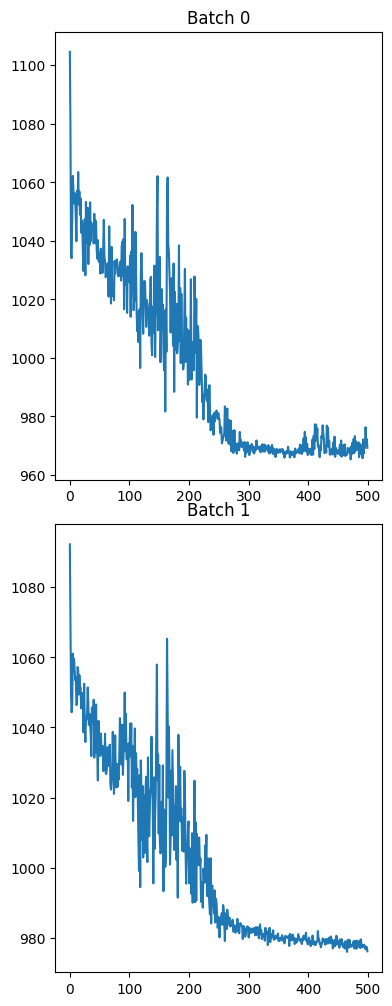

In [10]:
batch_plots(batch_loss_dict)

Done
tensor([[[ 5.7572e-02,  0.0000e+00, -1.0135e-09,  ...,  9.1919e-01,
          -8.4450e-05, -9.7684e-22],
         [ 7.4331e-02,  0.0000e+00, -1.9606e-08,  ...,  5.2168e-02,
          -1.6339e-03, -1.8896e-20],
         [ 3.0201e-01,  0.0000e+00,  4.6129e-07,  ..., -8.6134e-03,
           3.8571e-02,  4.4459e-19],
         ...,
         [ 6.3100e-02,  0.0000e+00, -1.4397e-14,  ...,  7.4295e-10,
          -3.6076e-02,  4.5273e-16],
         [ 5.5677e-02,  0.0000e+00,  9.3130e-16,  ..., -4.8060e-11,
           2.3001e-03, -2.9286e-17],
         [ 6.6134e-02,  0.0000e+00,  1.7930e-17,  ..., -9.2527e-13,
           4.4270e-05, -5.6383e-19]],

        [[ 5.9348e-02,  0.0000e+00, -1.1619e-09,  ...,  9.2361e-01,
          -7.2596e-05, -3.1401e-29],
         [ 8.9895e-02,  0.0000e+00, -3.3693e-08,  ...,  6.3584e-02,
          -2.1055e-03, -9.1063e-28],
         [ 2.7994e-01,  0.0000e+00,  6.0138e-07,  ..., -1.6676e-02,
           3.7701e-02,  1.6253e-26],
         ...,
         [ 7.0483e-0

 _  _   _  ___    _   _  _____ 
(_)( ) ( )(  _`\ ( ) ( )(_   _)
| || `\| || |_) )| | | |  | |  
| || , ` || ,__/'| | | |  | |  
| || |`\ || |    | (_) |  | |  
(_)(_) (_)(_)    (_____)  (_)  
                               
                               



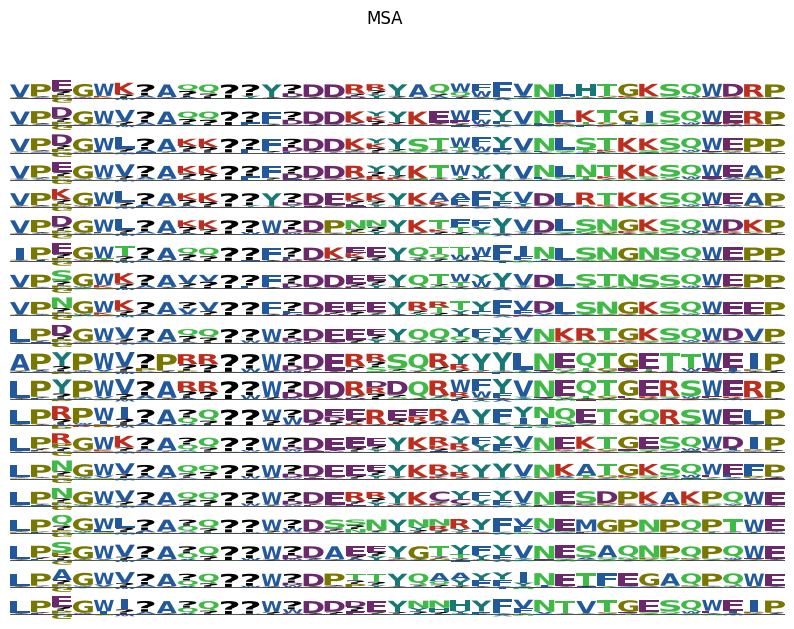

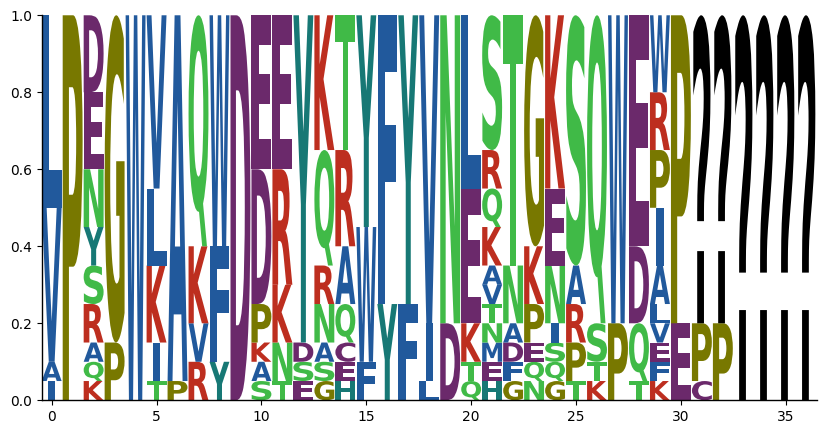

 ___    ___    ___    _____  _   _  ___   _____  ___    _   _  ___   _____  _ 
|  _`\ (  _`\ (  _`\ (  _  )( ) ( )(  _`\(_   _)|  _`\ ( ) ( )(  _`\(_   _)(_)
| (_) )| (_(_)| ( (_)| ( ) || `\| || (_(_) | |  | (_) )| | | || ( (_) | |  | |
| ,  / |  _)_ | |  _ | | | || , ` |`\__ \  | |  | ,  / | | | || |  _  | |  | |
| |\ \ | (_( )| (_( )| (_) || |`\ |( )_) | | |  | |\ \ | (_) || (_( ) | |  | |
(_) (_)(____/'(____/'(_____)(_) (_)`\____) (_)  (_) (_)(_____)(____/' (_)  (_)
                                                                              
                                                                              
 _____  _   _ 
(  _  )( ) ( )
| ( ) || `\| |
| | | || , ` |
| (_) || |`\ |
(_____)(_) (_)
              
              



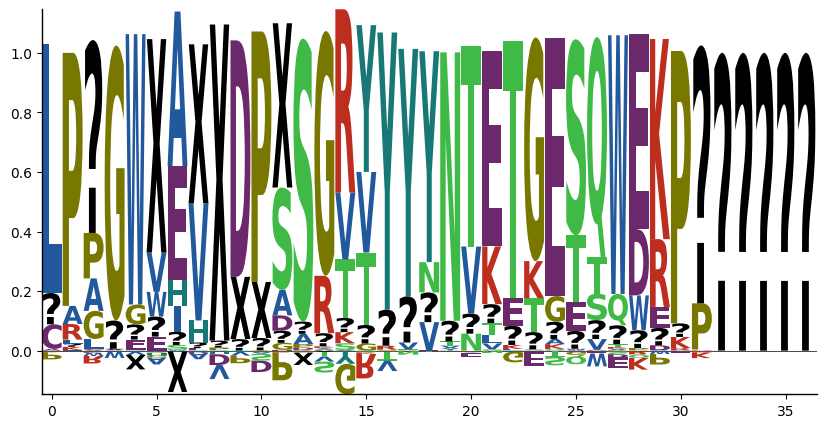

 _____  _      _  ___    _   _         ___    _   _  _____ 
(  _  )( )    (_)(  _`\ ( ) ( )/'\_/`\(  _`\ ( ) ( )(_   _)
| (_) || |    | || ( (_)| `\| ||     || (_(_)| `\| |  | |  
|  _  || |  _ | || |___ | , ` || (_) ||  _)_ | , ` |  | |  
| | | || |_( )| || (_, )| |`\ || | | || (_( )| |`\ |  | |  
(_) (_)(____/'(_)(____/'(_) (_)(_) (_)(____/'(_) (_)  (_)  
                                                           
                                                           



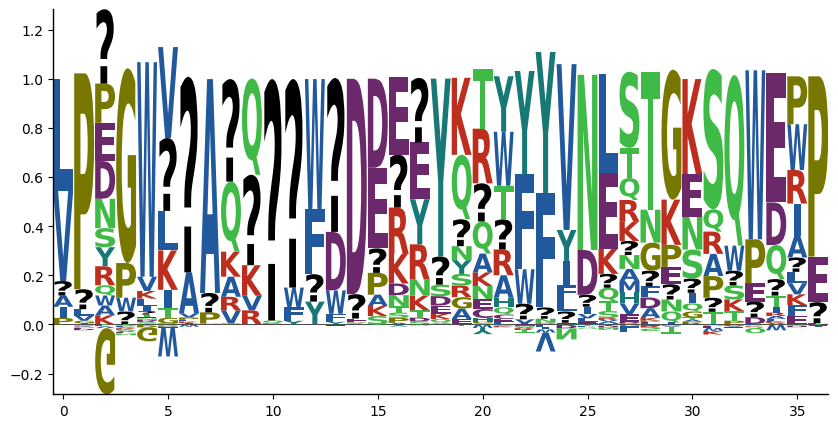

In [11]:
model.eval()
recon_data_train = model(dataset_msa.prot_space, deepseq)


print('Done')

from pyfiglet import Figlet
f = Figlet(font='puffy' ) #slant

print(recon_data_train[5])
alignment = recon_data_train[5]



plot_msa_from_preds(alignment.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)



print(f.renderText('INPUT'))
plot_logos_probs(dataset_msa.prot_space.detach().cpu(), alphabets)

print(f.renderText('RECONSTRUCTION'))
plot_logos_probs(recon_data_train[0].detach().cpu(), alphabets)

print(f.renderText('ALIGNMENT'))
plot_logos_probs(recon_data_train[5].detach().cpu(), alphabets)



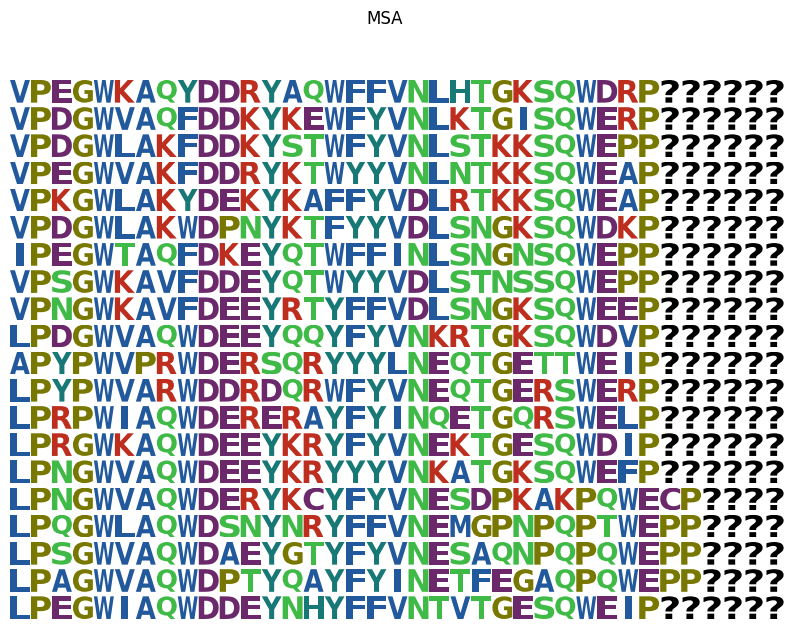

In [12]:
plot_msa_from_preds(trainloader.dataset.prot_space.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

IndexError: index 5 is out of bounds for axis 1 with size 5

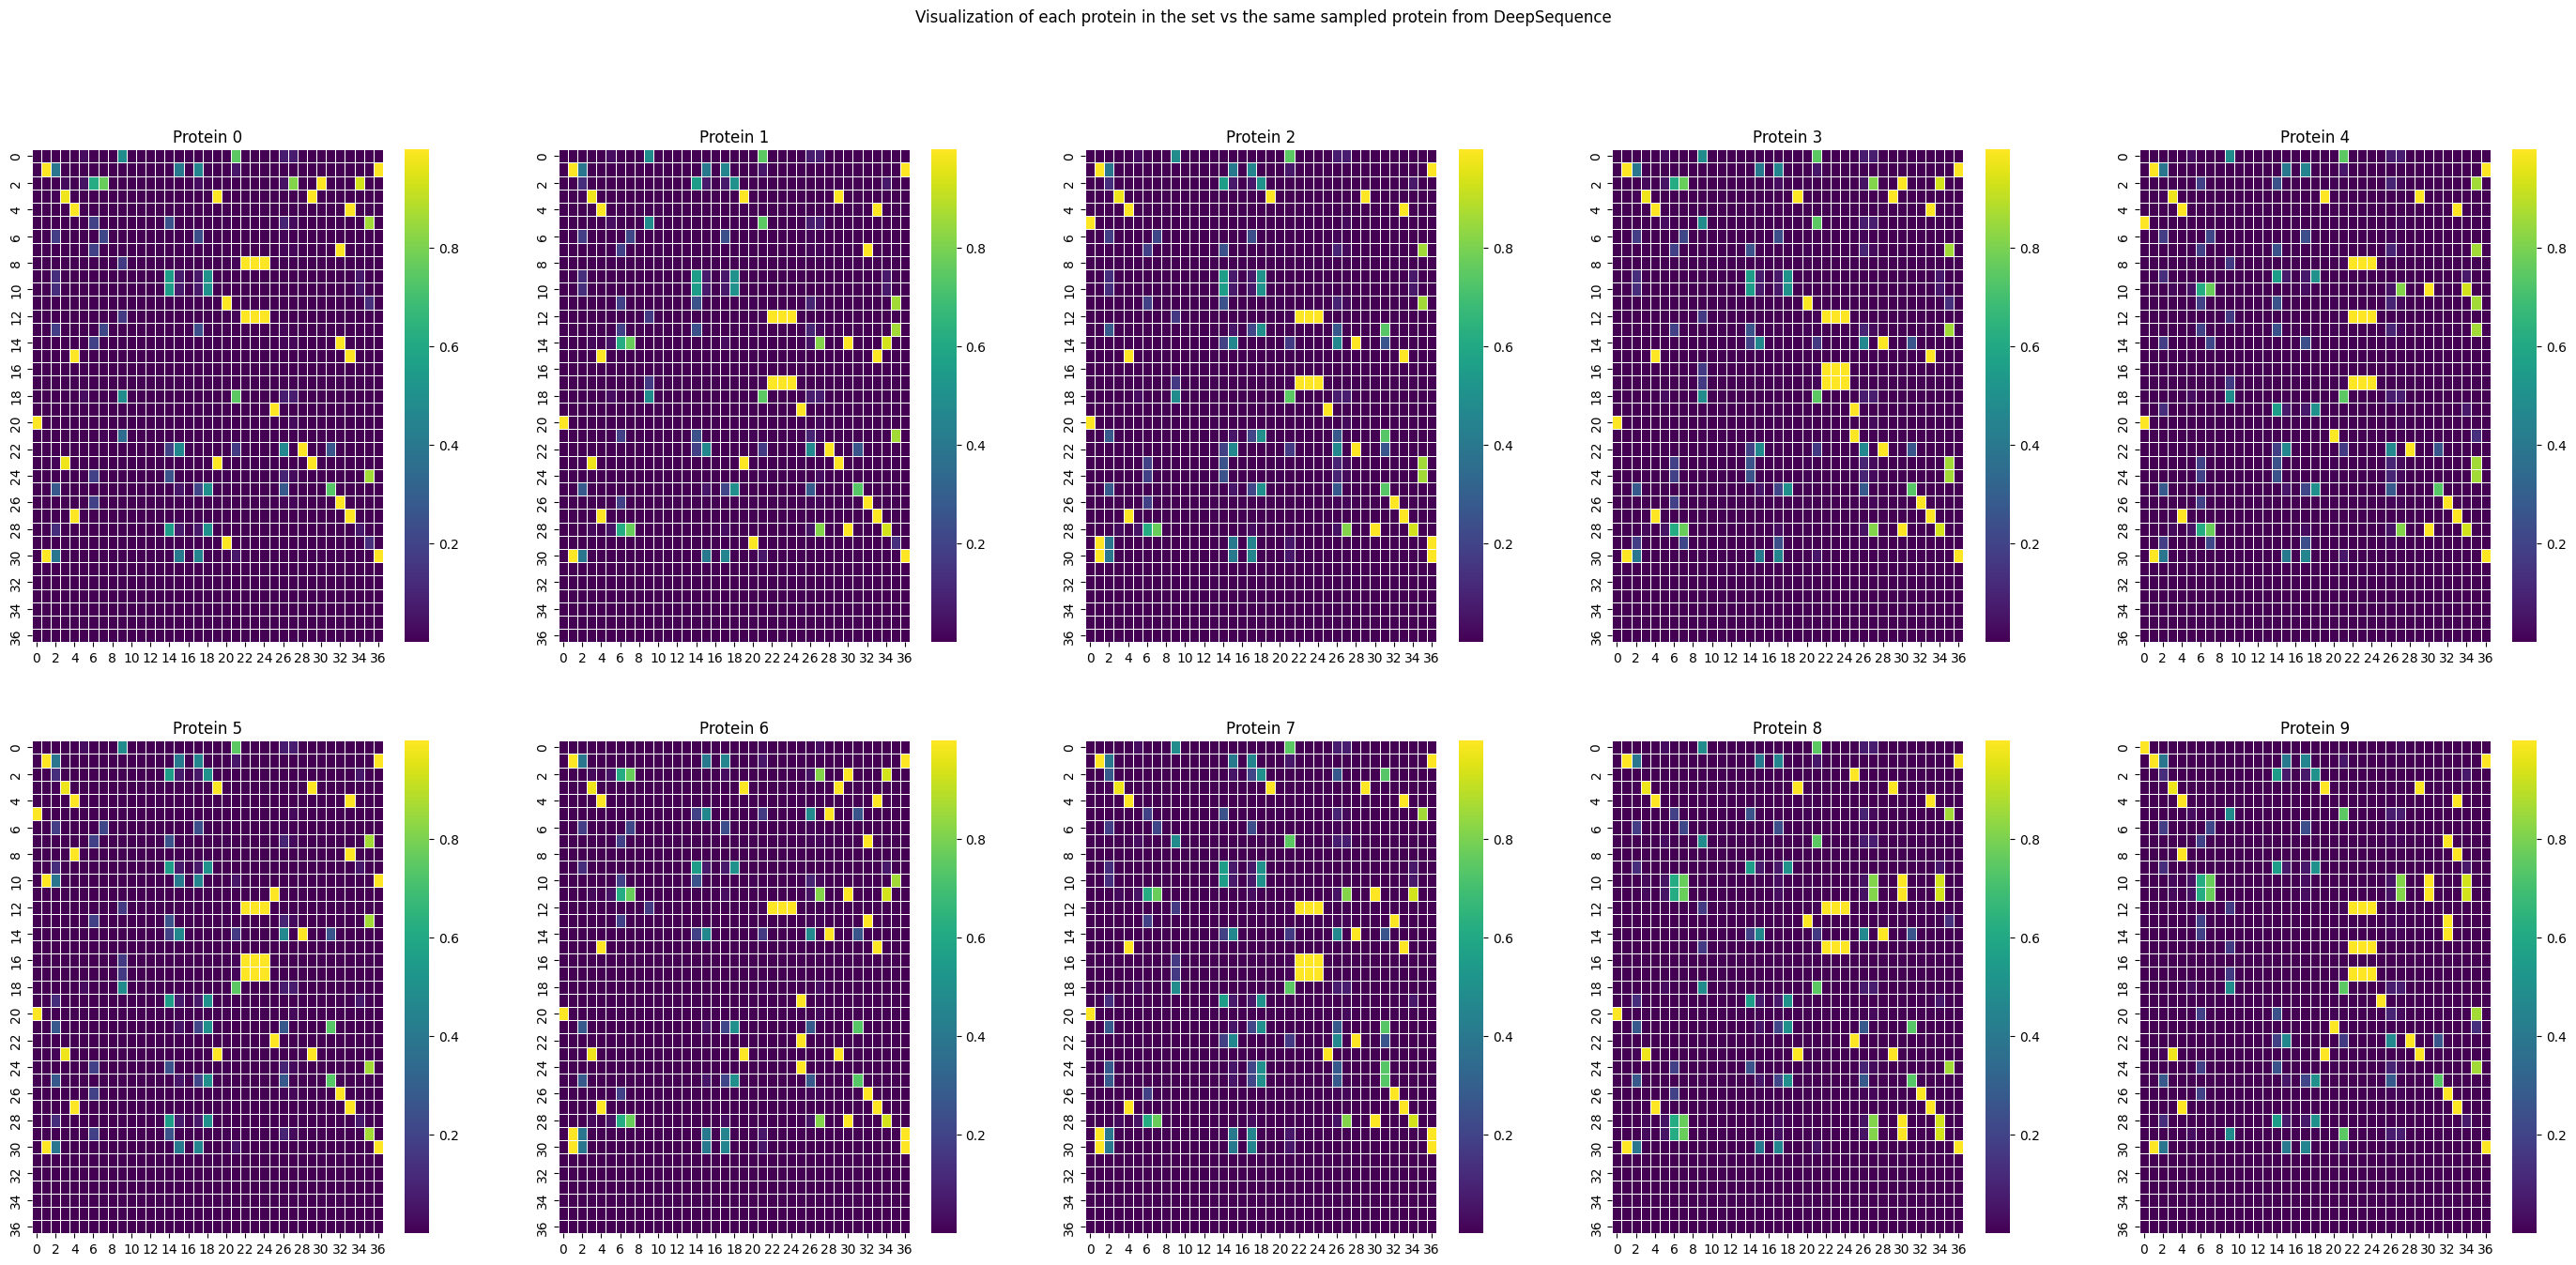

In [13]:
import seaborn as sns
import matplotlib.pylab as plt

def MonteCarlo_sampleDS(DS, iters):
    set_of_samples = [ DS.sample(1)[0] for i in range(0,iters)]
    MC_sample = torch.mean(torch.stack(set_of_samples), dim=0)
    return MC_sample

def energy_info_DSsampling_vs_Raw(DS, batch_seqs):

    #import ipdb; ipdb.set_trace()
    batch_size = batch_seqs.shape
    raw_seqs = batch_seqs; DS.eval()
    sampled_seqs = MonteCarlo_sampleDS(DS,100)

    sampled_seqs = sampled_seqs.permute(0,2,1)

    # One Sampled Protein from Deep Sequence vs all 10 proteins
    fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
    fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')
    list_of_attentions = []
    for cont, prot in enumerate(raw_seqs):
        # One Sampled Protein from Deep Sequence vs all 10 proteins
        ii,jj = ((1,cont-5), (0,cont))[cont < 5]
        seq = torch.matmul(prot,sampled_seqs[0])
        list_of_attentions.append(seq.detach().cpu())
        axes1vs10[ii,jj].set_title('Protein ' + str(cont))
        sns.heatmap(seq.detach().cpu().numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])
    
    plt.show()
    return list_of_attentions


import torch.nn.functional as F

def get_diagonal_attention(Matrix, comp, min_r, max_r, list_attention = []):
    # Works assuming that we are dealing with square matrixes
    if comp <= max_r and comp >= min_r:
        list_attention.append( torch.cat( (torch.tensor([0.0]*abs(comp)) , torch.diagonal(Matrix, comp)) ) )
        get_diagonal_attention(Matrix, comp-1, min_r, max_r, list_attention)

def get_batch_diagonal_attention(Matrix, comp, min_r, max_r):
    list_batch = []
    list_attention = []
    for m in Matrix:
        get_diagonal_attention(m, comp, min_r, max_r, list_attention )
        list_batch.append( torch.stack(list_attention) )
        list_attention.clear()

    batch_diag_attention = torch.stack(list_batch)
    return batch_diag_attention


attentions = energy_info_DSsampling_vs_Raw( deepseq, dataset_msa.prot_space.detach())



In [ ]:
att = get_batch_diagonal_attention(attentions,10,-10, 10)

figatt, axesatt = plt.subplots(2, 5, figsize=(35,15))
figatt.suptitle('Visualization attention diagonals')

for cont, at in enumerate(att):
    # One Sampled Protein from Deep Sequence vs all 10 proteins
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axesatt[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(at.numpy(), linewidth=0.5, cmap='viridis', ax=axesatt[ii,jj])
    
plt.show()

'''
Matrix = torch.tensor([[1,2,3,4,5],[33,44,55,66,77],[333,444,555,666,777],[3333,4444,5555,6666,7777],[33333,44444,55555,66666,77777]])
list_attention = []
get_diagonal_attention(Matrix, 2, -2, 2, list_attention)

Matrix2 = Matrix.repeat(2,1,1)
get_batch_diagonal_attention(Matrix2, 2, -2, 2)

print(list_attention)
'''

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm, Normalize

fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

def lognormalize(x):
    a = np.logaddexp.reduce(x)
    return np.exp(x - a)

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(prot.numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])

plt.show()

fig1vs10_log, axes1vs10_log = plt.subplots(2, 5, figsize=(35,15))
fig1vs10_log.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10_log[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap( prot.numpy() , linewidth=0.5, cmap='viridis', ax=axes1vs10_log[ii,jj], norm=LogNorm())

plt.show()